In [1]:
### Training models

import torch 
import os
from torch.utils.data.dataloader import DataLoader
import numpy as np
import pickle
from utils.dataset import ImitDataset, ImitDatasetTraj
from policy.sail_traj import ExtendedNetworkTraj
from policy.policy_factory import policy_factory
import configparser
import gym
import sys
sys.path.append('..')
from crowd_sim.envs.utils.robot import Robot
from crowd_sim.envs.crowd_sim import CrowdSim
from crowd_nav.utils.explorer import ExplorerDs
import matplotlib.pyplot as plt

from crowd_nav.imitate import *

In [2]:
args_traj = {'contrast_weight' : 0, 'policy' : 'sail_traj_simple', 'data_sample' : 0.7
                        , 'gpu' : True, 'batch_size' : 128, 'trajectory_weight' : 0, 'uni_weight' : 0.3, 
                       'output_dir' : 'data/tests/imitate', 'num_epoch' :100}

In [3]:
n_epochs = 200
for uni_l in range(1, 7) : 
    for m_obs in range(10, 0, -1) :
        outp = 'data/tests/imitate-{}'.format(m_obs)
        args = args_traj.copy()
        args['output_dir'] = outp
        args['uni_length'] = uni_l
        args['num_epoch'] = n_epochs
        _ = imitate(args_change=args)
 

2020-12-28 14:54:07, INFO:  =========================== 
2020-12-28 14:54:07, INFO: Current git head hash code: 521d1be24368618b2bbdcf354799fb02efe51656
2020-12-28 14:54:07, INFO: Using device: cuda
2020-12-28 14:54:07, INFO: Load data from data/demonstrate/data_imit_mem.pt
2020-12-28 14:54:09, INFO: +: 0 - 102427
2020-12-28 14:54:09, INFO: val_indices: 204856 - 292650


KeyboardInterrupt: 

In [23]:
import torch 
import os
from torch.utils.data.dataloader import DataLoader
import numpy as np
import pickle
from utils.dataset import ImitDataset, ImitDatasetTraj
from policy.sail_traj import ExtendedNetworkTraj
from policy.policy_factory import policy_factory
import configparser
import gym
import sys
sys.path.append('..')
from crowd_sim.envs.utils.robot import Robot
from crowd_sim.envs.crowd_sim import CrowdSim
from crowd_nav.utils.explorer import ExplorerDs

def test_model(m_p, model_type, visible=False, n_episodes=5000) :
    policy_p = 'configs/policy.config'
    if not visible : 
        env_p = 'configs/env.config'
    else :
        env_p = 'configs/env_visible.config'
    policy_type = model_type
    
    # configure policy
    policy = policy_factory[policy_type]()
    policy_config = configparser.RawConfigParser()
    policy_config.read(policy_p)
    policy.configure(policy_config)

    # configure environment
    env_config = configparser.RawConfigParser()
    env_config.read(env_p)
    env = CrowdSim()
    env.configure(env_config)

    robot = Robot(env_config, 'robot')
    robot.set_policy(policy)
    env.set_robot(robot)
    policy.set_env(env)

    policy.set_env(env)
    policy.set_phase('val')
    policy.set_device('cpu')

    policy.model.load_state_dict(torch.load(m_p))
    
    if model_type == 'sail' :
        explorer = ExplorerDs(env, robot, 'cpu', 1, gamma=0.9)
    else :
        explorer = ExplorerDs(env, robot, 'cpu', 5, gamma=0.9)
    explorer.robot = robot
    
    return explorer.run_k_episodes(n_episodes, 'val', progressbar=True, output_info=True, notebook=True)

def test(model_type='sail', visible=False, n_episodes=100, model_path=None, itera=range(4, 199, 5)) :
    res_list = []
    if model_path is None :
        if model_type != 'sail' :
            model_path = 'data/output/imitate-baseline-data-0.5-traj/'
        else :
            model_path = 'data/output/imitate-baseline-data-0.5-notraj/'
    for i in itera :
        s = str(i) if i > 10 else '0{}'.format(i)
        res = test_model(model_path + 'policy_net_{}.pth'.format(s), model_type=model_type, visible=visible, n_episodes=n_episodes)
        res_list.append((i, res))
    return res_list

In [42]:
results = {}
v = ['visible', 'invisible']
for vis in v :
    results[vis] = []
    for uni_l in range(1, 3) :
        results[vis].append([])
        for m_obs in range(10, 0, -1) :
            model_path = 'data/tests/imitate-{}-unipred-0.3-weight-{}-length-traj/'.format(m_obs, uni_l)
            visible = (vis=='visible') 
            results[vis][-1].append([test(model_type='sail_traj_simple', visible=visible, model_path=model_path)])
            
        

2020-12-27 09:55:07, INFO: VAL    success: 0.64, collision: 0.36, nav time: 10.65, reward: 0.1471 +- 0.2334


2020-12-27 09:55:14, INFO: VAL    success: 0.51, collision: 0.49, nav time: 9.74, reward: 0.0811 +- 0.2598


2020-12-27 09:55:22, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.45, reward: 0.2508 +- 0.1838


2020-12-27 09:55:30, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.35, reward: 0.2928 +- 0.1401


2020-12-27 09:55:39, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.48, reward: 0.2812 +- 0.1456


2020-12-27 09:55:48, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.55, reward: 0.3015 +- 0.1210


2020-12-27 09:55:55, INFO: VAL    success: 0.81, collision: 0.19, nav time: 10.13, reward: 0.2335 +- 0.2113


2020-12-27 09:56:04, INFO: VAL    success: 0.81, collision: 0.19, nav time: 10.28, reward: 0.2353 +- 0.2013


2020-12-27 09:56:13, INFO: VAL    success: 0.91, collision: 0.07, nav time: 10.41, reward: 0.2924 +- 0.1354


2020-12-27 09:56:22, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.44, reward: 0.2980 +- 0.1291


2020-12-27 09:56:31, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.31, reward: 0.2936 +- 0.1372


2020-12-27 09:56:40, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.39, reward: 0.2840 +- 0.1476


2020-12-27 09:56:49, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.33, reward: 0.3024 +- 0.1256


2020-12-27 09:56:59, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.17, reward: 0.2996 +- 0.1278


2020-12-27 09:57:08, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.43, reward: 0.3003 +- 0.1245


2020-12-27 09:57:19, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.59, reward: 0.2963 +- 0.1251


2020-12-27 09:57:28, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.52, reward: 0.3154 +- 0.0928


2020-12-27 09:57:36, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.46, reward: 0.3065 +- 0.1072


2020-12-27 09:57:47, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.36, reward: 0.3060 +- 0.1274


2020-12-27 09:57:56, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.21, reward: 0.2650 +- 0.1690


2020-12-27 09:58:05, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.32, reward: 0.3069 +- 0.1101


2020-12-27 09:58:14, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.35, reward: 0.2912 +- 0.1388


2020-12-27 09:58:23, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.51, reward: 0.3079 +- 0.1008


2020-12-27 09:58:32, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.15, reward: 0.2646 +- 0.1778


2020-12-27 09:58:42, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.53, reward: 0.3113 +- 0.1066


2020-12-27 09:58:52, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.49, reward: 0.3223 +- 0.0981


2020-12-27 09:59:03, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.28, reward: 0.2744 +- 0.1733


2020-12-27 09:59:12, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.25, reward: 0.3071 +- 0.1307


2020-12-27 09:59:22, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.44, reward: 0.2947 +- 0.1303


2020-12-27 09:59:32, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.49, reward: 0.3038 +- 0.1157


2020-12-27 09:59:42, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.54, reward: 0.2906 +- 0.1463


2020-12-27 09:59:55, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.59, reward: 0.2839 +- 0.1524


2020-12-27 10:00:08, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.51, reward: 0.3094 +- 0.1017


2020-12-27 10:00:18, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.43, reward: 0.2828 +- 0.1555


2020-12-27 10:00:28, INFO: VAL    success: 0.89, collision: 0.10, nav time: 10.21, reward: 0.2780 +- 0.1667


2020-12-27 10:00:40, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.52, reward: 0.3172 +- 0.0899


2020-12-27 10:00:50, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.55, reward: 0.3144 +- 0.0938


2020-12-27 10:01:00, INFO: VAL    success: 0.89, collision: 0.09, nav time: 10.45, reward: 0.2758 +- 0.1595


2020-12-27 10:01:10, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.36, reward: 0.3140 +- 0.1001


2020-12-27 10:01:17, INFO: VAL    success: 0.57, collision: 0.43, nav time: 10.37, reward: 0.1066 +- 0.2523


2020-12-27 10:01:27, INFO: VAL    success: 0.67, collision: 0.33, nav time: 10.33, reward: 0.1634 +- 0.2322


2020-12-27 10:01:36, INFO: VAL    success: 0.76, collision: 0.24, nav time: 10.33, reward: 0.2134 +- 0.2151


2020-12-27 10:01:44, INFO: VAL    success: 0.73, collision: 0.26, nav time: 9.96, reward: 0.2068 +- 0.2244


2020-12-27 10:01:53, INFO: VAL    success: 0.76, collision: 0.23, nav time: 10.40, reward: 0.2122 +- 0.2135


2020-12-27 10:02:03, INFO: VAL    success: 0.84, collision: 0.16, nav time: 10.21, reward: 0.2485 +- 0.1872


2020-12-27 10:02:12, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.28, reward: 0.2901 +- 0.1546


2020-12-27 10:02:23, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.37, reward: 0.3032 +- 0.1285


2020-12-27 10:02:33, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.08, reward: 0.3147 +- 0.1277


2020-12-27 10:02:45, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.48, reward: 0.2918 +- 0.1367


2020-12-27 10:02:55, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.58, reward: 0.3053 +- 0.1143


2020-12-27 10:03:04, INFO: VAL    success: 0.78, collision: 0.22, nav time: 10.06, reward: 0.2333 +- 0.2068


2020-12-27 10:03:14, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.20, reward: 0.3017 +- 0.1346


2020-12-27 10:03:23, INFO: VAL    success: 0.90, collision: 0.10, nav time: 9.99, reward: 0.2905 +- 0.1568


2020-12-27 10:03:33, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.32, reward: 0.3046 +- 0.1259


2020-12-27 10:03:42, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.18, reward: 0.3021 +- 0.1380


2020-12-27 10:03:53, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.47, reward: 0.3108 +- 0.1111


2020-12-27 10:04:02, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.19, reward: 0.2911 +- 0.1512


2020-12-27 10:04:12, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.21, reward: 0.2962 +- 0.1472


2020-12-27 10:04:21, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.28, reward: 0.2976 +- 0.1391


2020-12-27 10:04:31, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.31, reward: 0.3183 +- 0.1014


2020-12-27 10:04:41, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.38, reward: 0.2989 +- 0.1325


2020-12-27 10:04:50, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.42, reward: 0.2818 +- 0.1589


2020-12-27 10:04:59, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.23, reward: 0.2444 +- 0.1958


2020-12-27 10:05:09, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.44, reward: 0.3093 +- 0.1189


2020-12-27 10:05:18, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.13, reward: 0.2774 +- 0.1748


2020-12-27 10:05:27, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.43, reward: 0.2996 +- 0.1264


2020-12-27 10:05:36, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.37, reward: 0.2869 +- 0.1492


2020-12-27 10:05:46, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.28, reward: 0.2836 +- 0.1583


2020-12-27 10:05:56, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.40, reward: 0.2817 +- 0.1596


2020-12-27 10:06:05, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.64, reward: 0.2889 +- 0.1385


2020-12-27 10:06:14, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.22, reward: 0.2625 +- 0.1820


2020-12-27 10:06:24, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.50, reward: 0.2938 +- 0.1382


2020-12-27 10:06:34, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.65, reward: 0.2977 +- 0.1200


2020-12-27 10:06:45, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.38, reward: 0.3089 +- 0.1159


2020-12-27 10:06:55, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.44, reward: 0.2967 +- 0.1371


2020-12-27 10:07:04, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.42, reward: 0.2922 +- 0.1433


2020-12-27 10:07:15, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.46, reward: 0.3008 +- 0.1327


2020-12-27 10:07:24, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.32, reward: 0.3029 +- 0.1335


2020-12-27 10:07:33, INFO: VAL    success: 0.69, collision: 0.31, nav time: 10.21, reward: 0.1828 +- 0.2292


2020-12-27 10:07:42, INFO: VAL    success: 0.67, collision: 0.33, nav time: 10.14, reward: 0.1718 +- 0.2355


2020-12-27 10:07:52, INFO: VAL    success: 0.71, collision: 0.29, nav time: 10.37, reward: 0.1801 +- 0.2293


2020-12-27 10:08:04, INFO: VAL    success: 0.78, collision: 0.22, nav time: 10.13, reward: 0.2295 +- 0.2127


2020-12-27 10:08:15, INFO: VAL    success: 0.77, collision: 0.23, nav time: 10.33, reward: 0.2150 +- 0.2050


2020-12-27 10:08:25, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.42, reward: 0.2533 +- 0.1839


2020-12-27 10:08:34, INFO: VAL    success: 0.84, collision: 0.16, nav time: 10.26, reward: 0.2661 +- 0.1808


2020-12-27 10:08:44, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.22, reward: 0.2666 +- 0.1725


2020-12-27 10:08:54, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.39, reward: 0.3289 +- 0.0734


2020-12-27 10:09:03, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.34, reward: 0.2981 +- 0.1321


2020-12-27 10:09:12, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.36, reward: 0.2598 +- 0.1798


2020-12-27 10:09:23, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.28, reward: 0.2972 +- 0.1381


2020-12-27 10:09:33, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.42, reward: 0.3024 +- 0.1276


2020-12-27 10:09:43, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.27, reward: 0.2822 +- 0.1618


2020-12-27 10:09:54, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.38, reward: 0.2965 +- 0.1410


2020-12-27 10:10:04, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.30, reward: 0.2977 +- 0.1362


2020-12-27 10:10:14, INFO: VAL    success: 1.00, collision: 0.00, nav time: 10.62, reward: 0.3309 +- 0.0398


2020-12-27 10:10:23, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.41, reward: 0.3001 +- 0.1298


2020-12-27 10:10:33, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.30, reward: 0.2978 +- 0.1413


2020-12-27 10:10:43, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.45, reward: 0.3040 +- 0.1202


2020-12-27 10:10:53, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.51, reward: 0.3175 +- 0.0940


2020-12-27 10:11:02, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.23, reward: 0.2950 +- 0.1444


2020-12-27 10:11:12, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.40, reward: 0.3177 +- 0.1035


2020-12-27 10:11:21, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.27, reward: 0.2975 +- 0.1420


2020-12-27 10:11:31, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.27, reward: 0.3022 +- 0.1326


2020-12-27 10:11:40, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.39, reward: 0.2960 +- 0.1378


2020-12-27 10:11:51, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.48, reward: 0.2949 +- 0.1351


2020-12-27 10:12:01, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.37, reward: 0.3101 +- 0.1173


2020-12-27 10:12:11, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.29, reward: 0.2979 +- 0.1359


2020-12-27 10:12:20, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.42, reward: 0.2833 +- 0.1487


2020-12-27 10:12:30, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.54, reward: 0.3022 +- 0.1295


2020-12-27 10:12:39, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.53, reward: 0.3029 +- 0.1289


2020-12-27 10:12:49, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.34, reward: 0.2836 +- 0.1515


2020-12-27 10:12:58, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.40, reward: 0.3010 +- 0.1296


2020-12-27 10:13:08, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.34, reward: 0.3089 +- 0.1175


2020-12-27 10:13:17, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.16, reward: 0.2845 +- 0.1671


2020-12-27 10:13:26, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.32, reward: 0.3076 +- 0.1207


2020-12-27 10:13:36, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.47, reward: 0.3111 +- 0.1105


2020-12-27 10:13:45, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.24, reward: 0.3104 +- 0.1292


2020-12-27 10:13:55, INFO: VAL    success: 0.72, collision: 0.28, nav time: 10.49, reward: 0.1794 +- 0.2300


2020-12-27 10:14:03, INFO: VAL    success: 0.50, collision: 0.50, nav time: 10.04, reward: 0.0744 +- 0.2514


2020-12-27 10:14:12, INFO: VAL    success: 0.78, collision: 0.22, nav time: 10.21, reward: 0.2288 +- 0.2033


2020-12-27 10:14:22, INFO: VAL    success: 0.81, collision: 0.19, nav time: 10.22, reward: 0.2373 +- 0.1978


2020-12-27 10:14:32, INFO: VAL    success: 0.84, collision: 0.16, nav time: 10.68, reward: 0.2377 +- 0.1886


2020-12-27 10:14:42, INFO: VAL    success: 0.82, collision: 0.18, nav time: 10.14, reward: 0.2501 +- 0.1919


2020-12-27 10:14:52, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.29, reward: 0.2856 +- 0.1576


2020-12-27 10:15:02, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.16, reward: 0.2736 +- 0.1678


2020-12-27 10:15:12, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.21, reward: 0.3021 +- 0.1259


2020-12-27 10:15:22, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.43, reward: 0.3065 +- 0.1168


2020-12-27 10:15:32, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.37, reward: 0.3074 +- 0.1106


2020-12-27 10:15:42, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.54, reward: 0.2981 +- 0.1288


2020-12-27 10:15:52, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.38, reward: 0.3020 +- 0.1242


2020-12-27 10:16:02, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.44, reward: 0.3034 +- 0.1210


2020-12-27 10:16:13, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.63, reward: 0.3122 +- 0.0904


2020-12-27 10:16:23, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.40, reward: 0.3130 +- 0.0969


2020-12-27 10:16:32, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.38, reward: 0.2862 +- 0.1516


2020-12-27 10:16:41, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.45, reward: 0.3141 +- 0.1012


2020-12-27 10:16:51, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.32, reward: 0.2772 +- 0.1559


2020-12-27 10:17:00, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.39, reward: 0.3092 +- 0.1136


2020-12-27 10:17:10, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.42, reward: 0.2954 +- 0.1373


2020-12-27 10:17:21, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.67, reward: 0.3058 +- 0.1068


2020-12-27 10:17:32, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.46, reward: 0.3068 +- 0.1159


2020-12-27 10:17:44, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.26, reward: 0.2993 +- 0.1321


2020-12-27 10:17:56, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.22, reward: 0.3135 +- 0.1153


2020-12-27 10:18:05, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.17, reward: 0.3025 +- 0.1272


2020-12-27 10:18:14, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.31, reward: 0.2893 +- 0.1449


2020-12-27 10:18:23, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.37, reward: 0.2615 +- 0.1792


2020-12-27 10:18:32, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.27, reward: 0.3077 +- 0.1197


2020-12-27 10:18:42, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.53, reward: 0.3118 +- 0.1038


2020-12-27 10:18:50, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.04, reward: 0.2955 +- 0.1534


2020-12-27 10:19:00, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.59, reward: 0.3022 +- 0.1123


2020-12-27 10:19:09, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.35, reward: 0.3110 +- 0.1153


2020-12-27 10:19:18, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.27, reward: 0.2596 +- 0.1841


2020-12-27 10:19:28, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.49, reward: 0.2966 +- 0.1299


2020-12-27 10:19:37, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.47, reward: 0.2936 +- 0.1439


2020-12-27 10:19:46, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.17, reward: 0.3144 +- 0.1190


2020-12-27 10:19:56, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.45, reward: 0.3264 +- 0.0820


2020-12-27 10:20:05, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.25, reward: 0.3087 +- 0.1216


2020-12-27 10:20:13, INFO: VAL    success: 0.55, collision: 0.45, nav time: 10.22, reward: 0.0989 +- 0.2510


2020-12-27 10:20:22, INFO: VAL    success: 0.59, collision: 0.41, nav time: 10.20, reward: 0.1216 +- 0.2514


2020-12-27 10:20:31, INFO: VAL    success: 0.82, collision: 0.18, nav time: 10.30, reward: 0.2514 +- 0.1924


2020-12-27 10:20:39, INFO: VAL    success: 0.70, collision: 0.30, nav time: 10.20, reward: 0.1790 +- 0.2345


2020-12-27 10:20:48, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.44, reward: 0.2849 +- 0.1510


2020-12-27 10:20:56, INFO: VAL    success: 0.79, collision: 0.20, nav time: 10.00, reward: 0.2343 +- 0.2018


2020-12-27 10:21:05, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.29, reward: 0.3088 +- 0.1253


2020-12-27 10:21:14, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.42, reward: 0.2925 +- 0.1428


2020-12-27 10:21:22, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.19, reward: 0.2573 +- 0.1876


2020-12-27 10:21:31, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.33, reward: 0.3010 +- 0.1271


2020-12-27 10:21:40, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.32, reward: 0.3009 +- 0.1278


2020-12-27 10:21:49, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.31, reward: 0.2756 +- 0.1614


2020-12-27 10:21:58, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.45, reward: 0.3092 +- 0.1123


2020-12-27 10:22:08, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.39, reward: 0.3007 +- 0.1300


2020-12-27 10:22:17, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.17, reward: 0.2852 +- 0.1627


2020-12-27 10:22:27, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.47, reward: 0.2962 +- 0.1301


2020-12-27 10:22:36, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.51, reward: 0.3076 +- 0.1171


2020-12-27 10:22:46, INFO: VAL    success: 0.90, collision: 0.09, nav time: 10.26, reward: 0.2923 +- 0.1492


2020-12-27 10:22:56, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.64, reward: 0.3137 +- 0.0926


2020-12-27 10:23:05, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.21, reward: 0.2773 +- 0.1722


2020-12-27 10:23:14, INFO: VAL    success: 0.91, collision: 0.08, nav time: 10.49, reward: 0.2887 +- 0.1435


2020-12-27 10:23:23, INFO: VAL    success: 0.86, collision: 0.12, nav time: 10.43, reward: 0.2517 +- 0.1849


2020-12-27 10:23:32, INFO: VAL    success: 0.86, collision: 0.13, nav time: 10.45, reward: 0.2636 +- 0.1726


2020-12-27 10:23:41, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.61, reward: 0.3218 +- 0.0707


2020-12-27 10:23:53, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.51, reward: 0.2963 +- 0.1283


2020-12-27 10:24:03, INFO: VAL    success: 0.92, collision: 0.06, nav time: 10.47, reward: 0.2951 +- 0.1408


2020-12-27 10:24:12, INFO: VAL    success: 0.91, collision: 0.08, nav time: 10.62, reward: 0.2752 +- 0.1487


2020-12-27 10:24:21, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.58, reward: 0.3161 +- 0.0876


2020-12-27 10:24:31, INFO: VAL    success: 0.94, collision: 0.05, nav time: 10.68, reward: 0.3050 +- 0.1104


2020-12-27 10:24:40, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.34, reward: 0.2785 +- 0.1636


2020-12-27 10:24:50, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.58, reward: 0.3186 +- 0.0860


2020-12-27 10:24:59, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.67, reward: 0.2868 +- 0.1399


2020-12-27 10:25:09, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.40, reward: 0.3072 +- 0.1153


2020-12-27 10:25:18, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.56, reward: 0.2682 +- 0.1632


2020-12-27 10:25:28, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.72, reward: 0.2918 +- 0.1318


2020-12-27 10:25:37, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.21, reward: 0.2992 +- 0.1413


2020-12-27 10:25:46, INFO: VAL    success: 0.91, collision: 0.08, nav time: 10.32, reward: 0.2870 +- 0.1502


2020-12-27 10:25:56, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.44, reward: 0.3071 +- 0.1084


2020-12-27 10:26:06, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.56, reward: 0.3109 +- 0.0926


2020-12-27 10:26:13, INFO: VAL    success: 0.53, collision: 0.47, nav time: 10.24, reward: 0.0889 +- 0.2524


2020-12-27 10:26:21, INFO: VAL    success: 0.66, collision: 0.34, nav time: 10.35, reward: 0.1513 +- 0.2356


2020-12-27 10:26:28, INFO: VAL    success: 0.55, collision: 0.45, nav time: 10.14, reward: 0.0893 +- 0.2448


2020-12-27 10:26:38, INFO: VAL    success: 0.65, collision: 0.35, nav time: 10.30, reward: 0.1504 +- 0.2432


2020-12-27 10:26:47, INFO: VAL    success: 0.72, collision: 0.28, nav time: 10.08, reward: 0.1900 +- 0.2310


2020-12-27 10:26:57, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.28, reward: 0.2593 +- 0.1888


2020-12-27 10:27:08, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.21, reward: 0.2863 +- 0.1552


2020-12-27 10:27:17, INFO: VAL    success: 0.81, collision: 0.19, nav time: 9.83, reward: 0.2559 +- 0.2030


2020-12-27 10:27:31, INFO: VAL    success: 0.95, collision: 0.04, nav time: 10.40, reward: 0.3092 +- 0.1080


2020-12-27 10:27:44, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.33, reward: 0.2862 +- 0.1522


2020-12-27 10:27:57, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.35, reward: 0.2969 +- 0.1414


2020-12-27 10:28:10, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.39, reward: 0.2729 +- 0.1592


2020-12-27 10:28:21, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.35, reward: 0.2943 +- 0.1405


2020-12-27 10:28:31, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.35, reward: 0.3044 +- 0.1294


2020-12-27 10:28:40, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.42, reward: 0.2779 +- 0.1664


2020-12-27 10:28:51, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.46, reward: 0.2996 +- 0.1328


2020-12-27 10:29:00, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.45, reward: 0.2829 +- 0.1595


2020-12-27 10:29:11, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.44, reward: 0.2987 +- 0.1340


2020-12-27 10:29:21, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.40, reward: 0.2904 +- 0.1439


2020-12-27 10:29:31, INFO: VAL    success: 0.84, collision: 0.16, nav time: 10.28, reward: 0.2478 +- 0.1891


2020-12-27 10:29:41, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.53, reward: 0.3141 +- 0.0909


2020-12-27 10:29:52, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.32, reward: 0.2827 +- 0.1587


2020-12-27 10:30:02, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.53, reward: 0.2979 +- 0.1343


2020-12-27 10:30:12, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.65, reward: 0.2862 +- 0.1488


2020-12-27 10:30:21, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.40, reward: 0.3152 +- 0.1033


2020-12-27 10:30:31, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.35, reward: 0.2770 +- 0.1602


2020-12-27 10:30:41, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.36, reward: 0.2530 +- 0.1834


2020-12-27 10:30:53, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.65, reward: 0.3156 +- 0.0967


2020-12-27 10:31:03, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.23, reward: 0.2777 +- 0.1731


2020-12-27 10:31:15, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.40, reward: 0.3052 +- 0.1185


2020-12-27 10:31:25, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.38, reward: 0.3095 +- 0.1099


2020-12-27 10:31:35, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.49, reward: 0.3035 +- 0.1176


2020-12-27 10:31:47, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.28, reward: 0.2741 +- 0.1735


2020-12-27 10:31:58, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.30, reward: 0.3059 +- 0.1328


2020-12-27 10:32:08, INFO: VAL    success: 0.93, collision: 0.06, nav time: 10.27, reward: 0.3072 +- 0.1259


2020-12-27 10:32:19, INFO: VAL    success: 0.99, collision: 0.01, nav time: 10.81, reward: 0.3175 +- 0.0676


2020-12-27 10:32:32, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.60, reward: 0.2952 +- 0.1246


2020-12-27 10:32:43, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.37, reward: 0.2967 +- 0.1348


2020-12-27 10:32:56, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.55, reward: 0.2931 +- 0.1362


2020-12-27 10:33:02, INFO: VAL    success: 0.41, collision: 0.59, nav time: 9.87, reward: 0.0273 +- 0.2552


2020-12-27 10:33:10, INFO: VAL    success: 0.57, collision: 0.43, nav time: 10.26, reward: 0.1135 +- 0.2484


2020-12-27 10:33:20, INFO: VAL    success: 0.68, collision: 0.32, nav time: 10.26, reward: 0.1618 +- 0.2327


2020-12-27 10:33:29, INFO: VAL    success: 0.84, collision: 0.16, nav time: 10.45, reward: 0.2597 +- 0.1793


2020-12-27 10:33:38, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.36, reward: 0.2683 +- 0.1741


2020-12-27 10:33:47, INFO: VAL    success: 0.88, collision: 0.11, nav time: 10.40, reward: 0.2757 +- 0.1593


2020-12-27 10:33:57, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.26, reward: 0.2947 +- 0.1437


2020-12-27 10:34:06, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.40, reward: 0.2739 +- 0.1637


2020-12-27 10:34:15, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.45, reward: 0.2999 +- 0.1339


2020-12-27 10:34:25, INFO: VAL    success: 0.84, collision: 0.15, nav time: 10.29, reward: 0.2451 +- 0.1834


2020-12-27 10:34:35, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.39, reward: 0.3093 +- 0.1043


2020-12-27 10:34:45, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.53, reward: 0.2913 +- 0.1370


2020-12-27 10:34:55, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.40, reward: 0.2831 +- 0.1471


2020-12-27 10:35:07, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.43, reward: 0.3029 +- 0.1190


2020-12-27 10:35:17, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.45, reward: 0.3142 +- 0.0960


2020-12-27 10:35:27, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.45, reward: 0.2947 +- 0.1384


2020-12-27 10:35:36, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.32, reward: 0.2599 +- 0.1869


2020-12-27 10:35:47, INFO: VAL    success: 0.99, collision: 0.01, nav time: 10.67, reward: 0.3185 +- 0.0614


2020-12-27 10:36:00, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.33, reward: 0.3028 +- 0.1176


2020-12-27 10:36:12, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.45, reward: 0.2835 +- 0.1539


2020-12-27 10:36:22, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.36, reward: 0.2930 +- 0.1361


2020-12-27 10:36:32, INFO: VAL    success: 0.84, collision: 0.16, nav time: 10.20, reward: 0.2492 +- 0.1944


2020-12-27 10:36:41, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.48, reward: 0.2914 +- 0.1346


2020-12-27 10:36:52, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.39, reward: 0.2900 +- 0.1487


2020-12-27 10:37:01, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.29, reward: 0.2964 +- 0.1354


2020-12-27 10:37:10, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.54, reward: 0.2869 +- 0.1468


2020-12-27 10:37:20, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.41, reward: 0.3111 +- 0.1098


2020-12-27 10:37:31, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.48, reward: 0.2886 +- 0.1472


2020-12-27 10:37:41, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.51, reward: 0.3099 +- 0.1085


2020-12-27 10:37:51, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.48, reward: 0.2972 +- 0.1355


2020-12-27 10:38:00, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.40, reward: 0.3103 +- 0.1151


2020-12-27 10:38:09, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.32, reward: 0.3055 +- 0.1236


2020-12-27 10:38:18, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.49, reward: 0.2912 +- 0.1432


2020-12-27 10:38:27, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.36, reward: 0.2922 +- 0.1558


2020-12-27 10:38:35, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.39, reward: 0.2805 +- 0.1634


2020-12-27 10:38:44, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.57, reward: 0.3117 +- 0.1029


2020-12-27 10:38:53, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.63, reward: 0.2574 +- 0.1843


2020-12-27 10:39:01, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.34, reward: 0.2847 +- 0.1619


2020-12-27 10:39:10, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.72, reward: 0.3075 +- 0.0969


2020-12-27 10:39:17, INFO: VAL    success: 0.66, collision: 0.34, nav time: 10.13, reward: 0.1656 +- 0.2398


2020-12-27 10:39:25, INFO: VAL    success: 0.75, collision: 0.25, nav time: 10.27, reward: 0.2053 +- 0.2241


2020-12-27 10:39:32, INFO: VAL    success: 0.70, collision: 0.30, nav time: 10.25, reward: 0.1773 +- 0.2299


2020-12-27 10:39:40, INFO: VAL    success: 0.78, collision: 0.22, nav time: 10.34, reward: 0.2311 +- 0.2058


2020-12-27 10:39:49, INFO: VAL    success: 0.78, collision: 0.22, nav time: 9.96, reward: 0.2308 +- 0.2107


2020-12-27 10:39:57, INFO: VAL    success: 0.81, collision: 0.19, nav time: 10.28, reward: 0.2424 +- 0.1945


2020-12-27 10:40:05, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.48, reward: 0.3061 +- 0.1188


2020-12-27 10:40:14, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.30, reward: 0.2815 +- 0.1539


2020-12-27 10:40:22, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.42, reward: 0.3074 +- 0.1117


2020-12-27 10:40:31, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.47, reward: 0.2858 +- 0.1550


2020-12-27 10:40:39, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.33, reward: 0.2872 +- 0.1537


2020-12-27 10:40:48, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.38, reward: 0.2994 +- 0.1313


2020-12-27 10:40:56, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.24, reward: 0.3093 +- 0.1217


2020-12-27 10:41:05, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.45, reward: 0.3128 +- 0.1030


2020-12-27 10:41:14, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.43, reward: 0.3127 +- 0.0891


2020-12-27 10:41:22, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.47, reward: 0.3182 +- 0.0980


2020-12-27 10:41:31, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.55, reward: 0.3020 +- 0.1220


2020-12-27 10:41:41, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.48, reward: 0.3238 +- 0.0759


2020-12-27 10:41:50, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.41, reward: 0.3022 +- 0.1263


2020-12-27 10:41:59, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.23, reward: 0.3067 +- 0.1278


2020-12-27 10:42:08, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.46, reward: 0.3119 +- 0.1054


2020-12-27 10:42:17, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.65, reward: 0.3057 +- 0.1096


2020-12-27 10:42:26, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.40, reward: 0.3013 +- 0.1294


2020-12-27 10:42:34, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.53, reward: 0.2886 +- 0.1495


2020-12-27 10:42:43, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.21, reward: 0.2918 +- 0.1527


2020-12-27 10:42:52, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.18, reward: 0.2915 +- 0.1547


2020-12-27 10:43:00, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.36, reward: 0.3032 +- 0.1315


2020-12-27 10:43:09, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.42, reward: 0.3083 +- 0.1272


2020-12-27 10:43:18, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.38, reward: 0.2883 +- 0.1522


2020-12-27 10:43:27, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.37, reward: 0.2920 +- 0.1399


2020-12-27 10:43:36, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.46, reward: 0.3124 +- 0.1057


2020-12-27 10:43:44, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.34, reward: 0.3065 +- 0.1242


2020-12-27 10:43:54, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.48, reward: 0.3095 +- 0.1093


2020-12-27 10:44:03, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.34, reward: 0.2947 +- 0.1375


2020-12-27 10:44:11, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.53, reward: 0.2938 +- 0.1334


2020-12-27 10:44:20, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.61, reward: 0.2762 +- 0.1641


2020-12-27 10:44:28, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.33, reward: 0.2981 +- 0.1367


2020-12-27 10:44:36, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.39, reward: 0.3005 +- 0.1350


2020-12-27 10:44:45, INFO: VAL    success: 0.89, collision: 0.10, nav time: 10.32, reward: 0.2843 +- 0.1603


2020-12-27 10:44:51, INFO: VAL    success: 0.49, collision: 0.51, nav time: 9.85, reward: 0.0711 +- 0.2587


2020-12-27 10:44:57, INFO: VAL    success: 0.54, collision: 0.46, nav time: 9.93, reward: 0.0978 +- 0.2540


2020-12-27 10:45:05, INFO: VAL    success: 0.79, collision: 0.21, nav time: 10.40, reward: 0.2269 +- 0.2002


2020-12-27 10:45:14, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.68, reward: 0.2725 +- 0.1555


2020-12-27 10:45:22, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.30, reward: 0.2605 +- 0.1806


2020-12-27 10:45:30, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.29, reward: 0.2431 +- 0.2092


2020-12-27 10:45:38, INFO: VAL    success: 0.84, collision: 0.15, nav time: 10.16, reward: 0.2470 +- 0.1863


2020-12-27 10:45:46, INFO: VAL    success: 0.82, collision: 0.18, nav time: 10.40, reward: 0.2359 +- 0.2091


2020-12-27 10:45:56, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.67, reward: 0.2944 +- 0.1250


2020-12-27 10:46:05, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.52, reward: 0.2994 +- 0.1330


2020-12-27 10:46:13, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.60, reward: 0.2881 +- 0.1344


2020-12-27 10:46:22, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.39, reward: 0.3038 +- 0.1221


2020-12-27 10:46:31, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.42, reward: 0.2853 +- 0.1516


2020-12-27 10:46:39, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.34, reward: 0.2537 +- 0.1927


2020-12-27 10:46:47, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.35, reward: 0.2748 +- 0.1692


2020-12-27 10:46:56, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.40, reward: 0.2958 +- 0.1382


2020-12-27 10:47:04, INFO: VAL    success: 0.95, collision: 0.04, nav time: 10.46, reward: 0.3149 +- 0.1049


2020-12-27 10:47:13, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.38, reward: 0.3222 +- 0.0877


2020-12-27 10:47:22, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.34, reward: 0.3061 +- 0.1221


2020-12-27 10:47:31, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.24, reward: 0.2997 +- 0.1377


2020-12-27 10:47:40, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.25, reward: 0.2928 +- 0.1430


2020-12-27 10:47:50, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.33, reward: 0.3122 +- 0.1154


2020-12-27 10:48:00, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.53, reward: 0.3158 +- 0.0991


2020-12-27 10:48:09, INFO: VAL    success: 0.99, collision: 0.01, nav time: 10.46, reward: 0.3290 +- 0.0580


2020-12-27 10:48:19, INFO: VAL    success: 0.96, collision: 0.03, nav time: 10.57, reward: 0.3126 +- 0.0942


2020-12-27 10:48:28, INFO: VAL    success: 0.82, collision: 0.18, nav time: 10.25, reward: 0.2361 +- 0.2040


2020-12-27 10:48:37, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.51, reward: 0.3216 +- 0.0882


2020-12-27 10:48:45, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.22, reward: 0.2835 +- 0.1612


2020-12-27 10:48:54, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.45, reward: 0.2596 +- 0.1842


2020-12-27 10:49:03, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.46, reward: 0.3260 +- 0.0763


2020-12-27 10:49:12, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.40, reward: 0.3082 +- 0.1196


2020-12-27 10:49:21, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.29, reward: 0.3149 +- 0.1047


2020-12-27 10:49:29, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.41, reward: 0.3078 +- 0.1196


2020-12-27 10:49:38, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.32, reward: 0.3130 +- 0.1173


2020-12-27 10:49:47, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.38, reward: 0.2985 +- 0.1357


2020-12-27 10:49:56, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.33, reward: 0.2934 +- 0.1487


2020-12-27 10:50:05, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.48, reward: 0.3003 +- 0.1226


2020-12-27 10:50:13, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.29, reward: 0.2789 +- 0.1596


2020-12-27 10:50:22, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.46, reward: 0.3226 +- 0.0886


2020-12-27 10:50:28, INFO: VAL    success: 0.59, collision: 0.41, nav time: 9.83, reward: 0.1306 +- 0.2591


2020-12-27 10:50:35, INFO: VAL    success: 0.64, collision: 0.36, nav time: 10.50, reward: 0.1507 +- 0.2349


2020-12-27 10:50:42, INFO: VAL    success: 0.66, collision: 0.34, nav time: 9.81, reward: 0.1674 +- 0.2442


2020-12-27 10:50:51, INFO: VAL    success: 0.84, collision: 0.16, nav time: 10.34, reward: 0.2508 +- 0.1798


2020-12-27 10:50:59, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.40, reward: 0.2831 +- 0.1540


2020-12-27 10:51:07, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.22, reward: 0.2643 +- 0.1740


2020-12-27 10:51:15, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.21, reward: 0.2653 +- 0.1810


2020-12-27 10:51:23, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.07, reward: 0.2801 +- 0.1647


2020-12-27 10:51:32, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.39, reward: 0.2974 +- 0.1365


2020-12-27 10:51:40, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.23, reward: 0.2977 +- 0.1353


2020-12-27 10:51:49, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.32, reward: 0.3083 +- 0.1217


2020-12-27 10:51:57, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.34, reward: 0.3005 +- 0.1298


2020-12-27 10:52:06, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.38, reward: 0.3017 +- 0.1357


2020-12-27 10:52:14, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.13, reward: 0.2923 +- 0.1578


2020-12-27 10:52:23, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.42, reward: 0.3050 +- 0.1168


2020-12-27 10:52:31, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.29, reward: 0.3047 +- 0.1281


2020-12-27 10:52:39, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.35, reward: 0.2824 +- 0.1505


2020-12-27 10:52:47, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.27, reward: 0.3022 +- 0.1322


2020-12-27 10:52:56, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.43, reward: 0.2703 +- 0.1679


2020-12-27 10:53:04, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.33, reward: 0.3102 +- 0.1097


2020-12-27 10:53:13, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.42, reward: 0.3191 +- 0.0989


2020-12-27 10:53:21, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.28, reward: 0.3141 +- 0.1072


2020-12-27 10:53:29, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.53, reward: 0.2996 +- 0.1297


2020-12-27 10:53:38, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.44, reward: 0.3151 +- 0.1030


2020-12-27 10:53:47, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.28, reward: 0.3136 +- 0.1146


2020-12-27 10:53:56, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.47, reward: 0.2895 +- 0.1383


2020-12-27 10:54:05, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.31, reward: 0.2883 +- 0.1303


2020-12-27 10:54:14, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.50, reward: 0.3207 +- 0.0725


2020-12-27 10:54:23, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.30, reward: 0.3226 +- 0.0915


2020-12-27 10:54:32, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.51, reward: 0.3195 +- 0.0881


2020-12-27 10:54:41, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.39, reward: 0.3109 +- 0.1091


2020-12-27 10:54:50, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.40, reward: 0.2949 +- 0.1369


2020-12-27 10:54:59, INFO: VAL    success: 0.89, collision: 0.10, nav time: 10.24, reward: 0.2780 +- 0.1573


2020-12-27 10:55:08, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.41, reward: 0.3168 +- 0.1041


2020-12-27 10:55:17, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.50, reward: 0.3188 +- 0.0988


2020-12-27 10:55:26, INFO: VAL    success: 0.95, collision: 0.04, nav time: 10.36, reward: 0.3141 +- 0.1080


2020-12-27 10:55:34, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.29, reward: 0.2988 +- 0.1263


2020-12-27 10:55:43, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.40, reward: 0.2950 +- 0.1361


2020-12-27 10:55:53, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.35, reward: 0.3077 +- 0.1209


2020-12-27 10:56:00, INFO: VAL    success: 0.65, collision: 0.35, nav time: 10.44, reward: 0.1456 +- 0.2380


2020-12-27 10:56:08, INFO: VAL    success: 0.72, collision: 0.28, nav time: 10.37, reward: 0.1919 +- 0.2242


2020-12-27 10:56:17, INFO: VAL    success: 0.75, collision: 0.25, nav time: 10.57, reward: 0.1995 +- 0.2173


2020-12-27 10:56:24, INFO: VAL    success: 0.75, collision: 0.25, nav time: 10.51, reward: 0.2022 +- 0.2243


2020-12-27 10:56:33, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.59, reward: 0.2843 +- 0.1440


2020-12-27 10:56:41, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.36, reward: 0.2866 +- 0.1530


2020-12-27 10:56:50, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.65, reward: 0.2978 +- 0.1303


2020-12-27 10:56:58, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.37, reward: 0.3071 +- 0.1235


2020-12-27 10:57:07, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.32, reward: 0.3195 +- 0.1102


2020-12-27 10:57:15, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.47, reward: 0.3031 +- 0.1206


2020-12-27 10:57:24, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.46, reward: 0.3082 +- 0.1111


2020-12-27 10:57:32, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.36, reward: 0.2744 +- 0.1646


2020-12-27 10:57:41, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.39, reward: 0.3125 +- 0.1101


2020-12-27 10:57:51, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.35, reward: 0.2917 +- 0.1464


2020-12-27 10:57:59, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.40, reward: 0.3110 +- 0.1164


2020-12-27 10:58:08, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.31, reward: 0.3086 +- 0.1227


2020-12-27 10:58:17, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.43, reward: 0.2861 +- 0.1508


2020-12-27 10:58:26, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.45, reward: 0.3283 +- 0.0788


2020-12-27 10:58:35, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.42, reward: 0.3125 +- 0.1089


2020-12-27 10:58:43, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.49, reward: 0.2935 +- 0.1358


2020-12-27 10:58:51, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.22, reward: 0.2737 +- 0.1751


2020-12-27 10:59:00, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.31, reward: 0.2956 +- 0.1304


2020-12-27 10:59:09, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.57, reward: 0.3116 +- 0.1047


2020-12-27 10:59:18, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.25, reward: 0.2910 +- 0.1495


2020-12-27 10:59:26, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.24, reward: 0.3047 +- 0.1313


2020-12-27 10:59:35, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.39, reward: 0.3190 +- 0.0932


2020-12-27 10:59:43, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.33, reward: 0.3125 +- 0.1114


2020-12-27 10:59:52, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.29, reward: 0.2784 +- 0.1643


2020-12-27 11:00:01, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.20, reward: 0.2832 +- 0.1644


2020-12-27 11:00:09, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.59, reward: 0.3126 +- 0.1053


2020-12-27 11:00:18, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.33, reward: 0.2985 +- 0.1411


2020-12-27 11:00:26, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.48, reward: 0.2791 +- 0.1589


2020-12-27 11:00:36, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.49, reward: 0.3186 +- 0.0909


2020-12-27 11:00:45, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.42, reward: 0.2951 +- 0.1377


2020-12-27 11:00:53, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.22, reward: 0.3341 +- 0.0805


2020-12-27 11:01:02, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.28, reward: 0.2916 +- 0.1543


2020-12-27 11:01:11, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.35, reward: 0.3089 +- 0.1175


2020-12-27 11:01:20, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.55, reward: 0.2861 +- 0.1460


2020-12-27 11:01:29, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.27, reward: 0.2988 +- 0.1491


2020-12-27 11:01:35, INFO: VAL    success: 0.50, collision: 0.50, nav time: 10.04, reward: 0.0820 +- 0.2594


2020-12-27 11:01:43, INFO: VAL    success: 0.61, collision: 0.39, nav time: 10.39, reward: 0.1327 +- 0.2451


2020-12-27 11:01:51, INFO: VAL    success: 0.73, collision: 0.27, nav time: 10.04, reward: 0.2053 +- 0.2274


2020-12-27 11:02:00, INFO: VAL    success: 0.83, collision: 0.16, nav time: 10.41, reward: 0.2560 +- 0.1837


2020-12-27 11:02:08, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.24, reward: 0.2738 +- 0.1715


2020-12-27 11:02:17, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.36, reward: 0.2616 +- 0.1744


2020-12-27 11:02:25, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.15, reward: 0.2612 +- 0.1928


2020-12-27 11:02:34, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.39, reward: 0.3042 +- 0.1254


2020-12-27 11:02:43, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.24, reward: 0.2961 +- 0.1444


2020-12-27 11:02:51, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.19, reward: 0.2791 +- 0.1690


2020-12-27 11:03:00, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.36, reward: 0.3186 +- 0.0973


2020-12-27 11:03:08, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.33, reward: 0.3190 +- 0.0985


2020-12-27 11:03:16, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.42, reward: 0.2675 +- 0.1755


2020-12-27 11:03:25, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.25, reward: 0.2977 +- 0.1416


2020-12-27 11:03:33, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.36, reward: 0.3135 +- 0.1149


2020-12-27 11:03:42, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.38, reward: 0.3282 +- 0.0753


2020-12-27 11:03:50, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.34, reward: 0.2938 +- 0.1344


2020-12-27 11:03:59, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.43, reward: 0.3129 +- 0.1035


2020-12-27 11:04:08, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.53, reward: 0.2950 +- 0.1294


2020-12-27 11:04:16, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.43, reward: 0.2903 +- 0.1400


2020-12-27 11:04:25, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.35, reward: 0.2740 +- 0.1656


2020-12-27 11:04:33, INFO: VAL    success: 0.91, collision: 0.08, nav time: 10.26, reward: 0.2912 +- 0.1416


2020-12-27 11:04:42, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.26, reward: 0.3155 +- 0.1075


2020-12-27 11:04:51, INFO: VAL    success: 0.93, collision: 0.06, nav time: 10.41, reward: 0.2971 +- 0.1350


2020-12-27 11:04:59, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.34, reward: 0.3004 +- 0.1344


2020-12-27 11:05:08, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.43, reward: 0.2926 +- 0.1468


2020-12-27 11:05:17, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.50, reward: 0.3123 +- 0.1037


2020-12-27 11:05:25, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.40, reward: 0.2949 +- 0.1443


2020-12-27 11:05:34, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.28, reward: 0.2943 +- 0.1395


2020-12-27 11:05:43, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.49, reward: 0.3125 +- 0.1155


2020-12-27 11:05:52, INFO: VAL    success: 0.93, collision: 0.06, nav time: 10.47, reward: 0.3004 +- 0.1307


2020-12-27 11:06:01, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.45, reward: 0.2946 +- 0.1317


2020-12-27 11:06:10, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.24, reward: 0.3235 +- 0.0944


2020-12-27 11:06:18, INFO: VAL    success: 0.93, collision: 0.06, nav time: 10.54, reward: 0.2975 +- 0.1265


2020-12-27 11:06:27, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.52, reward: 0.3066 +- 0.1239


2020-12-27 11:06:36, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.59, reward: 0.3190 +- 0.0837


2020-12-27 11:06:45, INFO: VAL    success: 0.90, collision: 0.09, nav time: 10.55, reward: 0.2786 +- 0.1560


2020-12-27 11:06:54, INFO: VAL    success: 0.96, collision: 0.03, nav time: 10.42, reward: 0.3140 +- 0.1004


2020-12-27 11:07:03, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.52, reward: 0.2986 +- 0.1291


2020-12-27 11:07:11, INFO: VAL    success: 0.70, collision: 0.30, nav time: 10.40, reward: 0.1795 +- 0.2262


2020-12-27 11:07:18, INFO: VAL    success: 0.59, collision: 0.41, nav time: 9.84, reward: 0.1351 +- 0.2499


2020-12-27 11:07:26, INFO: VAL    success: 0.70, collision: 0.30, nav time: 9.90, reward: 0.1857 +- 0.2359


2020-12-27 11:07:35, INFO: VAL    success: 0.79, collision: 0.21, nav time: 10.45, reward: 0.2310 +- 0.1974


2020-12-27 11:07:43, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.48, reward: 0.2441 +- 0.1820


2020-12-27 11:07:52, INFO: VAL    success: 0.81, collision: 0.19, nav time: 10.19, reward: 0.2378 +- 0.2075


2020-12-27 11:08:00, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.18, reward: 0.2793 +- 0.1672


2020-12-27 11:08:09, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.21, reward: 0.2904 +- 0.1428


2020-12-27 11:08:17, INFO: VAL    success: 0.81, collision: 0.19, nav time: 10.25, reward: 0.2343 +- 0.2199


2020-12-27 11:08:26, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.28, reward: 0.2870 +- 0.1573


2020-12-27 11:08:34, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.33, reward: 0.2929 +- 0.1501


2020-12-27 11:08:43, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.36, reward: 0.2774 +- 0.1626


2020-12-27 11:08:52, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.41, reward: 0.3085 +- 0.1206


2020-12-27 11:09:01, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.51, reward: 0.2992 +- 0.1318


2020-12-27 11:09:10, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.28, reward: 0.3043 +- 0.1244


2020-12-27 11:09:19, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.29, reward: 0.3148 +- 0.1048


2020-12-27 11:09:28, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.54, reward: 0.3048 +- 0.1202


2020-12-27 11:09:36, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.32, reward: 0.3197 +- 0.1059


2020-12-27 11:09:45, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.52, reward: 0.3102 +- 0.1000


2020-12-27 11:09:54, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.60, reward: 0.2575 +- 0.1776


2020-12-27 11:10:02, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.29, reward: 0.2773 +- 0.1681


2020-12-27 11:10:10, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.35, reward: 0.2906 +- 0.1457


2020-12-27 11:10:18, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.38, reward: 0.2866 +- 0.1601


2020-12-27 11:10:27, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.51, reward: 0.3095 +- 0.1105


2020-12-27 11:10:36, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.52, reward: 0.2965 +- 0.1274


2020-12-27 11:10:47, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.37, reward: 0.2876 +- 0.1448


2020-12-27 11:10:58, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.43, reward: 0.2980 +- 0.1229


2020-12-27 11:11:09, INFO: VAL    success: 0.99, collision: 0.01, nav time: 10.58, reward: 0.3255 +- 0.0608


2020-12-27 11:11:19, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.30, reward: 0.2915 +- 0.1499


2020-12-27 11:11:29, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.43, reward: 0.3063 +- 0.1223


2020-12-27 11:11:38, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.33, reward: 0.3040 +- 0.1206


2020-12-27 11:11:48, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.27, reward: 0.3224 +- 0.0950


2020-12-27 11:11:58, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.38, reward: 0.3214 +- 0.0869


2020-12-27 11:12:08, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.55, reward: 0.3177 +- 0.0903


2020-12-27 11:12:17, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.45, reward: 0.3098 +- 0.1159


2020-12-27 11:12:27, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.37, reward: 0.3023 +- 0.1351


2020-12-27 11:12:37, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.64, reward: 0.3104 +- 0.1035


2020-12-27 11:12:46, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.46, reward: 0.3079 +- 0.1133


2020-12-27 11:12:56, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.46, reward: 0.3002 +- 0.1323


FileNotFoundError: [Errno 2] No such file or directory: 'data/tests/imitate-7-unipred-0.3-weight-2-length-traj/policy_net_04.pth'

In [43]:
#torch.save(results, 'results.pth')

In [3]:
results = torch.load('results.pth')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

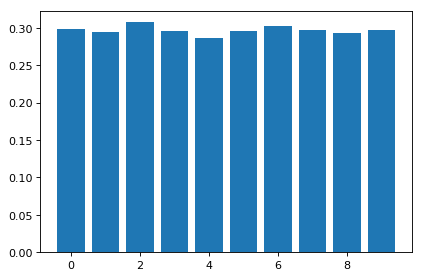

IndexError: list index out of range

In [30]:
for vis in ['visible', 'invisible'] :
    for uni_l in range(1, 3) :
        avgs = []
        for m_obs in range(10, 0, -1) :
            avg = np.mean([res[1]['reward'] for res in results[vis][uni_l-1][m_obs-1][0]][10:20])
            avgs.append(avg)
        plt.figure(dpi=80)
        x = range(len(avgs))
        plt.bar(x, avgs)
        plt.show()
            
        

In [24]:
model_path = 'data/output/imitate-event-data-0.5-weight-0.5-horizon-4-temperature-0.20-nboundary-0-notraj/'
model_results = test('sail', visible=True, model_path=model_path, n_episodes=100)

In [31]:
np.mean([res[1]['reward'] for res in model_results][10:20])

0.29064795974479585

## Testing traj 

In [1]:
### Training models

import torch 
import os
from torch.utils.data.dataloader import DataLoader
import numpy as np
import pickle
from utils.dataset import ImitDataset, ImitDatasetTraj
from policy.sail_traj import ExtendedNetworkTraj
from policy.policy_factory import policy_factory
import configparser
import gym
import sys
sys.path.append('..')
from crowd_sim.envs.utils.robot import Robot
from crowd_sim.envs.crowd_sim import CrowdSim
from crowd_nav.utils.explorer import ExplorerDs
import matplotlib.pyplot as plt

from crowd_nav.imitate import *

In [4]:
args_traj = {'contrast_weight' : 0, 'policy' : 'sail_traj_simple', 'data_sample' : 0.7
            , 'gpu' : True, 'batch_size' : 128, 'trajectory_weight' : 0.4, 'trajectory_length' : 5, 
            'uni_weight' : 0, 'output_dir' : 'data/tests/imitatetests', 'num_epoch' : 200}
args_uni = {'contrast_weight' : 0, 'policy' : 'sail_traj_simple', 'data_sample' : 0.7
            , 'gpu' : True, 'batch_size' : 128, 'uni_weight' : 0.4, 'uni_length' : 5, 
            'trajectory_weight' : 0, 'output_dir' : 'data/tests/imitatetests', 'num_epoch' : 200}

In [5]:
_ = imitate(args_change=args_traj)

2020-12-27 13:36:18, INFO:  =========================== 
2020-12-27 13:36:18, INFO: Current git head hash code: 521d1be24368618b2bbdcf354799fb02efe51656
2020-12-27 13:36:18, INFO: Using device: cuda
2020-12-27 13:36:18, INFO: Load data from data/demonstrate/data_imit_mem.pt
2020-12-27 13:36:18, INFO: +: 0 - 102427
2020-12-27 13:36:18, INFO: val_indices: 204856 - 292650


Epoch #0: loss = (0.1893, 0.0665), task = (0.1893, 0.0665), nce = (0.0000, 0.0000), tpred = (0.2985, 0.0148), upred = (0.0000, 0.0000)


Epoch #1: loss = (0.0625, 0.0665), task = (0.0625, 0.0665), nce = (0.0000, 0.0000), tpred = (0.0114, 0.0108), upred = (0.0000, 0.0000)


Epoch #2: loss = (0.0600, 0.0606), task = (0.0600, 0.0606), nce = (0.0000, 0.0000), tpred = (0.0093, 0.0100), upred = (0.0000, 0.0000)


Epoch #3: loss = (0.0587, 0.0599), task = (0.0587, 0.0599), nce = (0.0000, 0.0000), tpred = (0.0085, 0.0089), upred = (0.0000, 0.0000)


Epoch #4: loss = (0.0578, 0.0579), task = (0.0578, 0.0579), nce = (0.0000, 0.0000), tpred = (0.0081, 0.0082), upred = (0.0000, 0.0000)


Epoch #5: loss = (0.0572, 0.0587), task = (0.0572, 0.0587), nce = (0.0000, 0.0000), tpred = (0.0078, 0.0080), upred = (0.0000, 0.0000)


Epoch #6: loss = (0.0563, 0.0592), task = (0.0563, 0.0592), nce = (0.0000, 0.0000), tpred = (0.0076, 0.0074), upred = (0.0000, 0.0000)


Epoch #7: loss = (0.0555, 0.0589), task = (0.0555, 0.0589), nce = (0.0000, 0.0000), tpred = (0.0074, 0.0080), upred = (0.0000, 0.0000)


Epoch #8: loss = (0.0549, 0.0564), task = (0.0549, 0.0564), nce = (0.0000, 0.0000), tpred = (0.0074, 0.0074), upred = (0.0000, 0.0000)


Epoch #9: loss = (0.0543, 0.0593), task = (0.0543, 0.0593), nce = (0.0000, 0.0000), tpred = (0.0073, 0.0082), upred = (0.0000, 0.0000)


Epoch #10: loss = (0.0540, 0.0552), task = (0.0540, 0.0552), nce = (0.0000, 0.0000), tpred = (0.0072, 0.0073), upred = (0.0000, 0.0000)


Epoch #11: loss = (0.0533, 0.0554), task = (0.0533, 0.0554), nce = (0.0000, 0.0000), tpred = (0.0071, 0.0077), upred = (0.0000, 0.0000)


Epoch #12: loss = (0.0529, 0.0554), task = (0.0529, 0.0554), nce = (0.0000, 0.0000), tpred = (0.0070, 0.0081), upred = (0.0000, 0.0000)


Epoch #13: loss = (0.0524, 0.0547), task = (0.0524, 0.0547), nce = (0.0000, 0.0000), tpred = (0.0069, 0.0074), upred = (0.0000, 0.0000)


Epoch #14: loss = (0.0524, 0.0541), task = (0.0524, 0.0541), nce = (0.0000, 0.0000), tpred = (0.0069, 0.0076), upred = (0.0000, 0.0000)


Epoch #15: loss = (0.0520, 0.0561), task = (0.0520, 0.0561), nce = (0.0000, 0.0000), tpred = (0.0069, 0.0074), upred = (0.0000, 0.0000)


Epoch #16: loss = (0.0518, 0.0541), task = (0.0518, 0.0541), nce = (0.0000, 0.0000), tpred = (0.0068, 0.0072), upred = (0.0000, 0.0000)


Epoch #17: loss = (0.0514, 0.0552), task = (0.0514, 0.0552), nce = (0.0000, 0.0000), tpred = (0.0067, 0.0073), upred = (0.0000, 0.0000)


Epoch #18: loss = (0.0512, 0.0533), task = (0.0512, 0.0533), nce = (0.0000, 0.0000), tpred = (0.0067, 0.0071), upred = (0.0000, 0.0000)


Epoch #19: loss = (0.0509, 0.0534), task = (0.0509, 0.0534), nce = (0.0000, 0.0000), tpred = (0.0066, 0.0072), upred = (0.0000, 0.0000)


Epoch #20: loss = (0.0506, 0.0539), task = (0.0506, 0.0539), nce = (0.0000, 0.0000), tpred = (0.0066, 0.0068), upred = (0.0000, 0.0000)


Epoch #21: loss = (0.0505, 0.0537), task = (0.0505, 0.0537), nce = (0.0000, 0.0000), tpred = (0.0065, 0.0068), upred = (0.0000, 0.0000)


Epoch #22: loss = (0.0503, 0.0559), task = (0.0503, 0.0559), nce = (0.0000, 0.0000), tpred = (0.0065, 0.0070), upred = (0.0000, 0.0000)


Epoch #23: loss = (0.0500, 0.0545), task = (0.0500, 0.0545), nce = (0.0000, 0.0000), tpred = (0.0064, 0.0070), upred = (0.0000, 0.0000)


Epoch #24: loss = (0.0498, 0.0532), task = (0.0498, 0.0532), nce = (0.0000, 0.0000), tpred = (0.0064, 0.0070), upred = (0.0000, 0.0000)


Epoch #25: loss = (0.0495, 0.0545), task = (0.0495, 0.0545), nce = (0.0000, 0.0000), tpred = (0.0064, 0.0067), upred = (0.0000, 0.0000)


Epoch #26: loss = (0.0496, 0.0530), task = (0.0496, 0.0530), nce = (0.0000, 0.0000), tpred = (0.0063, 0.0069), upred = (0.0000, 0.0000)


Epoch #27: loss = (0.0494, 0.0538), task = (0.0494, 0.0538), nce = (0.0000, 0.0000), tpred = (0.0063, 0.0066), upred = (0.0000, 0.0000)


Epoch #28: loss = (0.0491, 0.0535), task = (0.0491, 0.0535), nce = (0.0000, 0.0000), tpred = (0.0063, 0.0069), upred = (0.0000, 0.0000)


Epoch #29: loss = (0.0487, 0.0528), task = (0.0487, 0.0528), nce = (0.0000, 0.0000), tpred = (0.0062, 0.0066), upred = (0.0000, 0.0000)


Epoch #30: loss = (0.0487, 0.0532), task = (0.0487, 0.0532), nce = (0.0000, 0.0000), tpred = (0.0062, 0.0067), upred = (0.0000, 0.0000)


Epoch #31: loss = (0.0484, 0.0552), task = (0.0484, 0.0552), nce = (0.0000, 0.0000), tpred = (0.0062, 0.0069), upred = (0.0000, 0.0000)


Epoch #32: loss = (0.0484, 0.0526), task = (0.0484, 0.0526), nce = (0.0000, 0.0000), tpred = (0.0061, 0.0063), upred = (0.0000, 0.0000)


Epoch #33: loss = (0.0482, 0.0533), task = (0.0482, 0.0533), nce = (0.0000, 0.0000), tpred = (0.0061, 0.0063), upred = (0.0000, 0.0000)


Epoch #34: loss = (0.0480, 0.0528), task = (0.0480, 0.0528), nce = (0.0000, 0.0000), tpred = (0.0060, 0.0064), upred = (0.0000, 0.0000)


Epoch #35: loss = (0.0478, 0.0535), task = (0.0478, 0.0535), nce = (0.0000, 0.0000), tpred = (0.0059, 0.0062), upred = (0.0000, 0.0000)


Epoch #36: loss = (0.0477, 0.0551), task = (0.0477, 0.0551), nce = (0.0000, 0.0000), tpred = (0.0059, 0.0065), upred = (0.0000, 0.0000)


Epoch #37: loss = (0.0476, 0.0529), task = (0.0476, 0.0529), nce = (0.0000, 0.0000), tpred = (0.0059, 0.0064), upred = (0.0000, 0.0000)


Epoch #38: loss = (0.0472, 0.0525), task = (0.0472, 0.0525), nce = (0.0000, 0.0000), tpred = (0.0058, 0.0061), upred = (0.0000, 0.0000)


Epoch #39: loss = (0.0472, 0.0529), task = (0.0472, 0.0529), nce = (0.0000, 0.0000), tpred = (0.0058, 0.0064), upred = (0.0000, 0.0000)


Epoch #40: loss = (0.0469, 0.0528), task = (0.0469, 0.0528), nce = (0.0000, 0.0000), tpred = (0.0057, 0.0067), upred = (0.0000, 0.0000)


Epoch #41: loss = (0.0467, 0.0526), task = (0.0467, 0.0526), nce = (0.0000, 0.0000), tpred = (0.0057, 0.0061), upred = (0.0000, 0.0000)


Epoch #42: loss = (0.0467, 0.0528), task = (0.0467, 0.0528), nce = (0.0000, 0.0000), tpred = (0.0056, 0.0063), upred = (0.0000, 0.0000)


Epoch #43: loss = (0.0466, 0.0530), task = (0.0466, 0.0530), nce = (0.0000, 0.0000), tpred = (0.0056, 0.0062), upred = (0.0000, 0.0000)


Epoch #44: loss = (0.0465, 0.0526), task = (0.0465, 0.0526), nce = (0.0000, 0.0000), tpred = (0.0056, 0.0061), upred = (0.0000, 0.0000)


Epoch #45: loss = (0.0463, 0.0533), task = (0.0463, 0.0533), nce = (0.0000, 0.0000), tpred = (0.0056, 0.0059), upred = (0.0000, 0.0000)


Epoch #46: loss = (0.0461, 0.0541), task = (0.0461, 0.0541), nce = (0.0000, 0.0000), tpred = (0.0056, 0.0063), upred = (0.0000, 0.0000)


Epoch #47: loss = (0.0460, 0.0532), task = (0.0460, 0.0532), nce = (0.0000, 0.0000), tpred = (0.0055, 0.0061), upred = (0.0000, 0.0000)


Epoch #48: loss = (0.0459, 0.0530), task = (0.0459, 0.0530), nce = (0.0000, 0.0000), tpred = (0.0055, 0.0059), upred = (0.0000, 0.0000)


Epoch #49: loss = (0.0456, 0.0531), task = (0.0456, 0.0531), nce = (0.0000, 0.0000), tpred = (0.0055, 0.0060), upred = (0.0000, 0.0000)


Epoch #50: loss = (0.0456, 0.0542), task = (0.0456, 0.0542), nce = (0.0000, 0.0000), tpred = (0.0055, 0.0059), upred = (0.0000, 0.0000)


Epoch #51: loss = (0.0456, 0.0525), task = (0.0456, 0.0525), nce = (0.0000, 0.0000), tpred = (0.0054, 0.0062), upred = (0.0000, 0.0000)


Epoch #52: loss = (0.0454, 0.0533), task = (0.0454, 0.0533), nce = (0.0000, 0.0000), tpred = (0.0054, 0.0058), upred = (0.0000, 0.0000)


Epoch #53: loss = (0.0454, 0.0540), task = (0.0454, 0.0540), nce = (0.0000, 0.0000), tpred = (0.0054, 0.0060), upred = (0.0000, 0.0000)


Epoch #54: loss = (0.0452, 0.0541), task = (0.0452, 0.0541), nce = (0.0000, 0.0000), tpred = (0.0054, 0.0058), upred = (0.0000, 0.0000)


Epoch #55: loss = (0.0451, 0.0531), task = (0.0451, 0.0531), nce = (0.0000, 0.0000), tpred = (0.0054, 0.0057), upred = (0.0000, 0.0000)


Epoch #56: loss = (0.0447, 0.0539), task = (0.0447, 0.0539), nce = (0.0000, 0.0000), tpred = (0.0054, 0.0058), upred = (0.0000, 0.0000)


Epoch #57: loss = (0.0450, 0.0533), task = (0.0450, 0.0533), nce = (0.0000, 0.0000), tpred = (0.0054, 0.0056), upred = (0.0000, 0.0000)


Epoch #58: loss = (0.0445, 0.0527), task = (0.0445, 0.0527), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0057), upred = (0.0000, 0.0000)


Epoch #59: loss = (0.0447, 0.0529), task = (0.0447, 0.0529), nce = (0.0000, 0.0000), tpred = (0.0054, 0.0056), upred = (0.0000, 0.0000)


Epoch #60: loss = (0.0445, 0.0534), task = (0.0445, 0.0534), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0057), upred = (0.0000, 0.0000)


Epoch #61: loss = (0.0443, 0.0546), task = (0.0443, 0.0546), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0061), upred = (0.0000, 0.0000)


Epoch #62: loss = (0.0444, 0.0532), task = (0.0444, 0.0532), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0057), upred = (0.0000, 0.0000)


Epoch #63: loss = (0.0442, 0.0545), task = (0.0442, 0.0545), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0057), upred = (0.0000, 0.0000)


Epoch #64: loss = (0.0443, 0.0538), task = (0.0443, 0.0538), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0056), upred = (0.0000, 0.0000)


Epoch #65: loss = (0.0438, 0.0535), task = (0.0438, 0.0535), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0057), upred = (0.0000, 0.0000)


Epoch #66: loss = (0.0438, 0.0539), task = (0.0438, 0.0539), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0058), upred = (0.0000, 0.0000)


Epoch #67: loss = (0.0438, 0.0540), task = (0.0438, 0.0540), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0057), upred = (0.0000, 0.0000)


Epoch #68: loss = (0.0439, 0.0541), task = (0.0439, 0.0541), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0057), upred = (0.0000, 0.0000)


Epoch #69: loss = (0.0437, 0.0534), task = (0.0437, 0.0534), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0057), upred = (0.0000, 0.0000)


Epoch #70: loss = (0.0435, 0.0537), task = (0.0435, 0.0537), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0055), upred = (0.0000, 0.0000)


Epoch #71: loss = (0.0435, 0.0537), task = (0.0435, 0.0537), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0056), upred = (0.0000, 0.0000)


Epoch #72: loss = (0.0432, 0.0545), task = (0.0432, 0.0545), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0060), upred = (0.0000, 0.0000)


Epoch #73: loss = (0.0433, 0.0544), task = (0.0433, 0.0544), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0057), upred = (0.0000, 0.0000)


Epoch #74: loss = (0.0430, 0.0545), task = (0.0430, 0.0545), nce = (0.0000, 0.0000), tpred = (0.0053, 0.0057), upred = (0.0000, 0.0000)


Epoch #75: loss = (0.0430, 0.0538), task = (0.0430, 0.0538), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0056), upred = (0.0000, 0.0000)


Epoch #76: loss = (0.0429, 0.0540), task = (0.0429, 0.0540), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0056), upred = (0.0000, 0.0000)


Epoch #77: loss = (0.0427, 0.0540), task = (0.0427, 0.0540), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0056), upred = (0.0000, 0.0000)


Epoch #78: loss = (0.0427, 0.0540), task = (0.0427, 0.0540), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0058), upred = (0.0000, 0.0000)


Epoch #79: loss = (0.0426, 0.0540), task = (0.0426, 0.0540), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0060), upred = (0.0000, 0.0000)


Epoch #80: loss = (0.0424, 0.0548), task = (0.0424, 0.0548), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0059), upred = (0.0000, 0.0000)


Epoch #81: loss = (0.0424, 0.0547), task = (0.0424, 0.0547), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0058), upred = (0.0000, 0.0000)


Epoch #82: loss = (0.0425, 0.0544), task = (0.0425, 0.0544), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0057), upred = (0.0000, 0.0000)


Epoch #83: loss = (0.0424, 0.0538), task = (0.0424, 0.0538), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0058), upred = (0.0000, 0.0000)


Epoch #84: loss = (0.0422, 0.0547), task = (0.0422, 0.0547), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0056), upred = (0.0000, 0.0000)


Epoch #85: loss = (0.0420, 0.0544), task = (0.0420, 0.0544), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0057), upred = (0.0000, 0.0000)


Epoch #86: loss = (0.0420, 0.0539), task = (0.0420, 0.0539), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0057), upred = (0.0000, 0.0000)


Epoch #87: loss = (0.0419, 0.0543), task = (0.0419, 0.0543), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0057), upred = (0.0000, 0.0000)


Epoch #88: loss = (0.0419, 0.0542), task = (0.0419, 0.0542), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0059), upred = (0.0000, 0.0000)


Epoch #89: loss = (0.0421, 0.0546), task = (0.0421, 0.0546), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0059), upred = (0.0000, 0.0000)


Epoch #90: loss = (0.0417, 0.0551), task = (0.0417, 0.0551), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0057), upred = (0.0000, 0.0000)


Epoch #91: loss = (0.0418, 0.0544), task = (0.0418, 0.0544), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0058), upred = (0.0000, 0.0000)


Epoch #92: loss = (0.0416, 0.0556), task = (0.0416, 0.0556), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0056), upred = (0.0000, 0.0000)


Epoch #93: loss = (0.0418, 0.0549), task = (0.0418, 0.0549), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0056), upred = (0.0000, 0.0000)


Epoch #94: loss = (0.0413, 0.0545), task = (0.0413, 0.0545), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0057), upred = (0.0000, 0.0000)


Epoch #95: loss = (0.0411, 0.0563), task = (0.0411, 0.0563), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0058), upred = (0.0000, 0.0000)


Epoch #96: loss = (0.0412, 0.0554), task = (0.0412, 0.0554), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0056), upred = (0.0000, 0.0000)


Epoch #97: loss = (0.0410, 0.0545), task = (0.0410, 0.0545), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0057), upred = (0.0000, 0.0000)


Epoch #98: loss = (0.0413, 0.0550), task = (0.0413, 0.0550), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0059), upred = (0.0000, 0.0000)


Epoch #99: loss = (0.0410, 0.0550), task = (0.0410, 0.0550), nce = (0.0000, 0.0000), tpred = (0.0052, 0.0055), upred = (0.0000, 0.0000)


Epoch #100: loss = (0.0412, 0.0542), task = (0.0412, 0.0542), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0059), upred = (0.0000, 0.0000)


Epoch #101: loss = (0.0408, 0.0553), task = (0.0408, 0.0553), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0061), upred = (0.0000, 0.0000)


Epoch #102: loss = (0.0407, 0.0551), task = (0.0407, 0.0551), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0058), upred = (0.0000, 0.0000)


Epoch #103: loss = (0.0409, 0.0554), task = (0.0409, 0.0554), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0055), upred = (0.0000, 0.0000)


Epoch #104: loss = (0.0407, 0.0558), task = (0.0407, 0.0558), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0057), upred = (0.0000, 0.0000)


Epoch #105: loss = (0.0407, 0.0545), task = (0.0407, 0.0545), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0057), upred = (0.0000, 0.0000)


Epoch #106: loss = (0.0407, 0.0557), task = (0.0407, 0.0557), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0059), upred = (0.0000, 0.0000)


Epoch #107: loss = (0.0405, 0.0548), task = (0.0405, 0.0548), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0055), upred = (0.0000, 0.0000)


Epoch #108: loss = (0.0404, 0.0554), task = (0.0404, 0.0554), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0055), upred = (0.0000, 0.0000)


Epoch #109: loss = (0.0403, 0.0545), task = (0.0403, 0.0545), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0058), upred = (0.0000, 0.0000)


Epoch #110: loss = (0.0404, 0.0561), task = (0.0404, 0.0561), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0057), upred = (0.0000, 0.0000)


Epoch #111: loss = (0.0402, 0.0551), task = (0.0402, 0.0551), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0058), upred = (0.0000, 0.0000)


Epoch #112: loss = (0.0403, 0.0558), task = (0.0403, 0.0558), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0057), upred = (0.0000, 0.0000)


Epoch #113: loss = (0.0401, 0.0553), task = (0.0401, 0.0553), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0060), upred = (0.0000, 0.0000)


Epoch #114: loss = (0.0398, 0.0550), task = (0.0398, 0.0550), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0055), upred = (0.0000, 0.0000)


Epoch #115: loss = (0.0402, 0.0557), task = (0.0402, 0.0557), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0056), upred = (0.0000, 0.0000)


Epoch #116: loss = (0.0404, 0.0550), task = (0.0404, 0.0550), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0056), upred = (0.0000, 0.0000)


Epoch #117: loss = (0.0401, 0.0564), task = (0.0401, 0.0564), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0057), upred = (0.0000, 0.0000)


Epoch #118: loss = (0.0398, 0.0560), task = (0.0398, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0056), upred = (0.0000, 0.0000)


Epoch #119: loss = (0.0399, 0.0566), task = (0.0399, 0.0566), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0058), upred = (0.0000, 0.0000)


Epoch #120: loss = (0.0396, 0.0557), task = (0.0396, 0.0557), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0058), upred = (0.0000, 0.0000)


Epoch #121: loss = (0.0395, 0.0565), task = (0.0395, 0.0565), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0054), upred = (0.0000, 0.0000)


Epoch #122: loss = (0.0397, 0.0560), task = (0.0397, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0060), upred = (0.0000, 0.0000)


Epoch #123: loss = (0.0394, 0.0558), task = (0.0394, 0.0558), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0055), upred = (0.0000, 0.0000)


Epoch #124: loss = (0.0394, 0.0570), task = (0.0394, 0.0570), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0057), upred = (0.0000, 0.0000)


Epoch #125: loss = (0.0395, 0.0555), task = (0.0395, 0.0555), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0060), upred = (0.0000, 0.0000)


Epoch #126: loss = (0.0394, 0.0557), task = (0.0394, 0.0557), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0063), upred = (0.0000, 0.0000)


Epoch #127: loss = (0.0394, 0.0560), task = (0.0394, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0059), upred = (0.0000, 0.0000)


Epoch #128: loss = (0.0393, 0.0553), task = (0.0393, 0.0553), nce = (0.0000, 0.0000), tpred = (0.0051, 0.0056), upred = (0.0000, 0.0000)


Epoch #129: loss = (0.0392, 0.0556), task = (0.0392, 0.0556), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #130: loss = (0.0392, 0.0565), task = (0.0392, 0.0565), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #131: loss = (0.0390, 0.0564), task = (0.0390, 0.0564), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0057), upred = (0.0000, 0.0000)


Epoch #132: loss = (0.0392, 0.0562), task = (0.0392, 0.0562), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0061), upred = (0.0000, 0.0000)


Epoch #133: loss = (0.0393, 0.0557), task = (0.0393, 0.0557), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #134: loss = (0.0389, 0.0567), task = (0.0389, 0.0567), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #135: loss = (0.0386, 0.0563), task = (0.0386, 0.0563), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0054), upred = (0.0000, 0.0000)


Epoch #136: loss = (0.0388, 0.0561), task = (0.0388, 0.0561), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #137: loss = (0.0390, 0.0566), task = (0.0390, 0.0566), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #138: loss = (0.0388, 0.0573), task = (0.0388, 0.0573), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0058), upred = (0.0000, 0.0000)


Epoch #139: loss = (0.0387, 0.0584), task = (0.0387, 0.0584), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0057), upred = (0.0000, 0.0000)


Epoch #140: loss = (0.0385, 0.0570), task = (0.0385, 0.0570), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #141: loss = (0.0386, 0.0568), task = (0.0386, 0.0568), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0059), upred = (0.0000, 0.0000)


Epoch #142: loss = (0.0386, 0.0577), task = (0.0386, 0.0577), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #143: loss = (0.0384, 0.0576), task = (0.0384, 0.0576), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0057), upred = (0.0000, 0.0000)


Epoch #144: loss = (0.0386, 0.0571), task = (0.0386, 0.0571), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #145: loss = (0.0384, 0.0583), task = (0.0384, 0.0583), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #146: loss = (0.0383, 0.0578), task = (0.0383, 0.0578), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #147: loss = (0.0384, 0.0568), task = (0.0384, 0.0568), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0058), upred = (0.0000, 0.0000)


Epoch #148: loss = (0.0382, 0.0563), task = (0.0382, 0.0563), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #149: loss = (0.0385, 0.0563), task = (0.0385, 0.0563), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #150: loss = (0.0385, 0.0570), task = (0.0385, 0.0570), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #151: loss = (0.0383, 0.0570), task = (0.0383, 0.0570), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #152: loss = (0.0383, 0.0564), task = (0.0383, 0.0564), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #153: loss = (0.0380, 0.0570), task = (0.0380, 0.0570), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0057), upred = (0.0000, 0.0000)


Epoch #154: loss = (0.0380, 0.0575), task = (0.0380, 0.0575), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0054), upred = (0.0000, 0.0000)


Epoch #155: loss = (0.0382, 0.0576), task = (0.0382, 0.0576), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0054), upred = (0.0000, 0.0000)


Epoch #156: loss = (0.0379, 0.0569), task = (0.0379, 0.0569), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #157: loss = (0.0375, 0.0580), task = (0.0375, 0.0580), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #158: loss = (0.0379, 0.0571), task = (0.0379, 0.0571), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #159: loss = (0.0378, 0.0572), task = (0.0378, 0.0572), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #160: loss = (0.0379, 0.0572), task = (0.0379, 0.0572), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0059), upred = (0.0000, 0.0000)


Epoch #161: loss = (0.0376, 0.0576), task = (0.0376, 0.0576), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0060), upred = (0.0000, 0.0000)


Epoch #162: loss = (0.0377, 0.0574), task = (0.0377, 0.0574), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0057), upred = (0.0000, 0.0000)


Epoch #163: loss = (0.0379, 0.0582), task = (0.0379, 0.0582), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #164: loss = (0.0376, 0.0565), task = (0.0376, 0.0565), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #165: loss = (0.0373, 0.0578), task = (0.0373, 0.0578), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #166: loss = (0.0376, 0.0572), task = (0.0376, 0.0572), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #167: loss = (0.0373, 0.0579), task = (0.0373, 0.0579), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0058), upred = (0.0000, 0.0000)


Epoch #168: loss = (0.0373, 0.0578), task = (0.0373, 0.0578), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #169: loss = (0.0374, 0.0582), task = (0.0374, 0.0582), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0054), upred = (0.0000, 0.0000)


Epoch #170: loss = (0.0379, 0.0570), task = (0.0379, 0.0570), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #171: loss = (0.0371, 0.0587), task = (0.0371, 0.0587), nce = (0.0000, 0.0000), tpred = (0.0049, 0.0057), upred = (0.0000, 0.0000)


Epoch #172: loss = (0.0372, 0.0594), task = (0.0372, 0.0594), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0061), upred = (0.0000, 0.0000)


Epoch #173: loss = (0.0377, 0.0580), task = (0.0377, 0.0580), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #174: loss = (0.0375, 0.0568), task = (0.0375, 0.0568), nce = (0.0000, 0.0000), tpred = (0.0049, 0.0056), upred = (0.0000, 0.0000)


Epoch #175: loss = (0.0370, 0.0570), task = (0.0370, 0.0570), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0054), upred = (0.0000, 0.0000)


Epoch #176: loss = (0.0369, 0.0586), task = (0.0369, 0.0586), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0057), upred = (0.0000, 0.0000)


Epoch #177: loss = (0.0372, 0.0584), task = (0.0372, 0.0584), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0057), upred = (0.0000, 0.0000)


Epoch #178: loss = (0.0370, 0.0592), task = (0.0370, 0.0592), nce = (0.0000, 0.0000), tpred = (0.0049, 0.0056), upred = (0.0000, 0.0000)


Epoch #179: loss = (0.0369, 0.0563), task = (0.0369, 0.0563), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #180: loss = (0.0370, 0.0583), task = (0.0370, 0.0583), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #181: loss = (0.0369, 0.0580), task = (0.0369, 0.0580), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #182: loss = (0.0368, 0.0589), task = (0.0368, 0.0589), nce = (0.0000, 0.0000), tpred = (0.0049, 0.0055), upred = (0.0000, 0.0000)


Epoch #183: loss = (0.0369, 0.0577), task = (0.0369, 0.0577), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #184: loss = (0.0368, 0.0579), task = (0.0368, 0.0579), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #185: loss = (0.0368, 0.0584), task = (0.0368, 0.0584), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #186: loss = (0.0370, 0.0585), task = (0.0370, 0.0585), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0058), upred = (0.0000, 0.0000)


Epoch #187: loss = (0.0365, 0.0580), task = (0.0365, 0.0580), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #188: loss = (0.0367, 0.0586), task = (0.0367, 0.0586), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0058), upred = (0.0000, 0.0000)


Epoch #189: loss = (0.0365, 0.0581), task = (0.0365, 0.0581), nce = (0.0000, 0.0000), tpred = (0.0049, 0.0059), upred = (0.0000, 0.0000)


Epoch #190: loss = (0.0367, 0.0602), task = (0.0367, 0.0602), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #191: loss = (0.0364, 0.0581), task = (0.0364, 0.0581), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #192: loss = (0.0363, 0.0588), task = (0.0363, 0.0588), nce = (0.0000, 0.0000), tpred = (0.0049, 0.0058), upred = (0.0000, 0.0000)


Epoch #193: loss = (0.0365, 0.0579), task = (0.0365, 0.0579), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0057), upred = (0.0000, 0.0000)


Epoch #194: loss = (0.0363, 0.0577), task = (0.0363, 0.0577), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0054), upred = (0.0000, 0.0000)


Epoch #195: loss = (0.0366, 0.0590), task = (0.0366, 0.0590), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #196: loss = (0.0364, 0.0576), task = (0.0364, 0.0576), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0058), upred = (0.0000, 0.0000)


Epoch #197: loss = (0.0362, 0.0589), task = (0.0362, 0.0589), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0055), upred = (0.0000, 0.0000)


Epoch #198: loss = (0.0364, 0.0582), task = (0.0364, 0.0582), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0056), upred = (0.0000, 0.0000)


Epoch #199: loss = (0.0362, 0.0586), task = (0.0362, 0.0586), nce = (0.0000, 0.0000), tpred = (0.0050, 0.0057), upred = (0.0000, 0.0000)


In [6]:
_ = imitate(args_change=args_uni)

2020-12-27 14:38:02, INFO:  =========================== 
2020-12-27 14:38:02, INFO: Current git head hash code: 521d1be24368618b2bbdcf354799fb02efe51656
2020-12-27 14:38:02, INFO: Using device: cuda
2020-12-27 14:38:02, INFO: Load data from data/demonstrate/data_imit_mem.pt
2020-12-27 14:38:03, INFO: +: 0 - 102427
2020-12-27 14:38:03, INFO: val_indices: 204856 - 292650


Epoch #0: loss = (0.1478, 0.0722), task = (0.1478, 0.0722), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.2022, 0.0244)


Epoch #1: loss = (0.0665, 0.0659), task = (0.0665, 0.0659), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0226, 0.0221)


Epoch #2: loss = (0.0643, 0.0661), task = (0.0643, 0.0661), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0204, 0.0200)


Epoch #3: loss = (0.0630, 0.0643), task = (0.0630, 0.0643), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0192, 0.0202)


Epoch #4: loss = (0.0620, 0.0629), task = (0.0620, 0.0629), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0182, 0.0187)


Epoch #5: loss = (0.0611, 0.0618), task = (0.0611, 0.0618), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0175, 0.0174)


Epoch #6: loss = (0.0603, 0.0628), task = (0.0603, 0.0628), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0169, 0.0209)


Epoch #7: loss = (0.0598, 0.0617), task = (0.0598, 0.0617), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0167, 0.0173)


Epoch #8: loss = (0.0591, 0.0605), task = (0.0591, 0.0605), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0164, 0.0175)


Epoch #9: loss = (0.0584, 0.0600), task = (0.0584, 0.0600), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0160, 0.0164)


Epoch #10: loss = (0.0579, 0.0599), task = (0.0579, 0.0599), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0159, 0.0164)


Epoch #11: loss = (0.0575, 0.0589), task = (0.0575, 0.0589), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0157, 0.0153)


Epoch #12: loss = (0.0570, 0.0584), task = (0.0570, 0.0584), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0156, 0.0155)


Epoch #13: loss = (0.0565, 0.0586), task = (0.0565, 0.0586), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0154, 0.0155)


Epoch #14: loss = (0.0562, 0.0586), task = (0.0562, 0.0586), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0152, 0.0169)


Epoch #15: loss = (0.0559, 0.0577), task = (0.0559, 0.0577), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0150, 0.0154)


Epoch #16: loss = (0.0556, 0.0580), task = (0.0556, 0.0580), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0148, 0.0152)


Epoch #17: loss = (0.0552, 0.0578), task = (0.0552, 0.0578), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0147, 0.0147)


Epoch #18: loss = (0.0549, 0.0579), task = (0.0549, 0.0579), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0144, 0.0150)


Epoch #19: loss = (0.0545, 0.0573), task = (0.0545, 0.0573), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0143, 0.0151)


Epoch #20: loss = (0.0542, 0.0572), task = (0.0542, 0.0572), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0142, 0.0142)


Epoch #21: loss = (0.0538, 0.0564), task = (0.0538, 0.0564), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0140, 0.0146)


Epoch #22: loss = (0.0535, 0.0568), task = (0.0535, 0.0568), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0137, 0.0143)


Epoch #23: loss = (0.0533, 0.0561), task = (0.0533, 0.0561), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0137, 0.0142)


Epoch #24: loss = (0.0531, 0.0574), task = (0.0531, 0.0574), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0134, 0.0149)


Epoch #25: loss = (0.0528, 0.0572), task = (0.0528, 0.0572), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0133, 0.0145)


Epoch #26: loss = (0.0527, 0.0571), task = (0.0527, 0.0571), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0134, 0.0140)


Epoch #27: loss = (0.0524, 0.0562), task = (0.0524, 0.0562), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0132, 0.0138)


Epoch #28: loss = (0.0523, 0.0562), task = (0.0523, 0.0562), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0131, 0.0139)


Epoch #29: loss = (0.0520, 0.0564), task = (0.0520, 0.0564), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0129, 0.0139)


Epoch #30: loss = (0.0517, 0.0548), task = (0.0517, 0.0548), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0129, 0.0135)


Epoch #31: loss = (0.0515, 0.0572), task = (0.0515, 0.0572), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0127, 0.0146)


Epoch #32: loss = (0.0513, 0.0564), task = (0.0513, 0.0564), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0127, 0.0137)


Epoch #33: loss = (0.0512, 0.0558), task = (0.0512, 0.0558), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0126, 0.0142)


Epoch #34: loss = (0.0509, 0.0558), task = (0.0509, 0.0558), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0125, 0.0129)


Epoch #35: loss = (0.0508, 0.0552), task = (0.0508, 0.0552), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0124, 0.0129)


Epoch #36: loss = (0.0505, 0.0546), task = (0.0505, 0.0546), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0125, 0.0133)


Epoch #37: loss = (0.0504, 0.0557), task = (0.0504, 0.0557), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0123, 0.0141)


Epoch #38: loss = (0.0502, 0.0554), task = (0.0502, 0.0554), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0123, 0.0139)


Epoch #39: loss = (0.0502, 0.0559), task = (0.0502, 0.0559), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0123, 0.0136)


Epoch #40: loss = (0.0500, 0.0581), task = (0.0500, 0.0581), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0122, 0.0145)


Epoch #41: loss = (0.0500, 0.0549), task = (0.0500, 0.0549), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0123, 0.0132)


Epoch #42: loss = (0.0497, 0.0557), task = (0.0497, 0.0557), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0121, 0.0137)


Epoch #43: loss = (0.0498, 0.0550), task = (0.0498, 0.0550), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0121, 0.0135)


Epoch #44: loss = (0.0495, 0.0555), task = (0.0495, 0.0555), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0120, 0.0131)


Epoch #45: loss = (0.0495, 0.0548), task = (0.0495, 0.0548), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0121, 0.0130)


Epoch #46: loss = (0.0491, 0.0561), task = (0.0491, 0.0561), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0119, 0.0131)


Epoch #47: loss = (0.0493, 0.0552), task = (0.0493, 0.0552), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0120, 0.0136)


Epoch #48: loss = (0.0491, 0.0558), task = (0.0491, 0.0558), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0119, 0.0127)


Epoch #49: loss = (0.0489, 0.0550), task = (0.0489, 0.0550), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0119, 0.0130)


Epoch #50: loss = (0.0487, 0.0554), task = (0.0487, 0.0554), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0118, 0.0133)


Epoch #51: loss = (0.0486, 0.0567), task = (0.0486, 0.0567), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0119, 0.0147)


Epoch #52: loss = (0.0487, 0.0553), task = (0.0487, 0.0553), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0119, 0.0142)


Epoch #53: loss = (0.0485, 0.0546), task = (0.0485, 0.0546), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0118, 0.0131)


Epoch #54: loss = (0.0483, 0.0560), task = (0.0483, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0117, 0.0126)


Epoch #55: loss = (0.0485, 0.0550), task = (0.0485, 0.0550), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0118, 0.0127)


Epoch #56: loss = (0.0483, 0.0545), task = (0.0483, 0.0545), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0118, 0.0129)


Epoch #57: loss = (0.0480, 0.0550), task = (0.0480, 0.0550), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0117, 0.0137)


Epoch #58: loss = (0.0480, 0.0557), task = (0.0480, 0.0557), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0117, 0.0133)


Epoch #59: loss = (0.0479, 0.0562), task = (0.0479, 0.0562), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0118, 0.0134)


Epoch #60: loss = (0.0479, 0.0550), task = (0.0479, 0.0550), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0128)


Epoch #61: loss = (0.0475, 0.0551), task = (0.0475, 0.0551), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0117, 0.0127)


Epoch #62: loss = (0.0478, 0.0560), task = (0.0478, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0140)


Epoch #63: loss = (0.0477, 0.0560), task = (0.0477, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0118, 0.0135)


Epoch #64: loss = (0.0475, 0.0551), task = (0.0475, 0.0551), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0126)


Epoch #65: loss = (0.0474, 0.0556), task = (0.0474, 0.0556), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0117, 0.0124)


Epoch #66: loss = (0.0473, 0.0560), task = (0.0473, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0117, 0.0134)


Epoch #67: loss = (0.0473, 0.0557), task = (0.0473, 0.0557), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0128)


Epoch #68: loss = (0.0470, 0.0574), task = (0.0470, 0.0574), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0135)


Epoch #69: loss = (0.0471, 0.0559), task = (0.0471, 0.0559), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0130)


Epoch #70: loss = (0.0469, 0.0563), task = (0.0469, 0.0563), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0132)


Epoch #71: loss = (0.0467, 0.0558), task = (0.0467, 0.0558), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0124)


Epoch #72: loss = (0.0468, 0.0561), task = (0.0468, 0.0561), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0128)


Epoch #73: loss = (0.0467, 0.0560), task = (0.0467, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0127)


Epoch #74: loss = (0.0466, 0.0560), task = (0.0466, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0134)


Epoch #75: loss = (0.0466, 0.0557), task = (0.0466, 0.0557), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0126)


Epoch #76: loss = (0.0464, 0.0565), task = (0.0464, 0.0565), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0127)


Epoch #77: loss = (0.0464, 0.0570), task = (0.0464, 0.0570), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0147)


Epoch #78: loss = (0.0463, 0.0555), task = (0.0463, 0.0555), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0128)


Epoch #79: loss = (0.0464, 0.0555), task = (0.0464, 0.0555), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0125)


Epoch #80: loss = (0.0461, 0.0560), task = (0.0461, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0127)


Epoch #81: loss = (0.0461, 0.0562), task = (0.0461, 0.0562), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0124)


Epoch #82: loss = (0.0460, 0.0579), task = (0.0460, 0.0579), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0136)


Epoch #83: loss = (0.0459, 0.0565), task = (0.0459, 0.0565), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0129)


Epoch #84: loss = (0.0459, 0.0559), task = (0.0459, 0.0559), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0124)


Epoch #85: loss = (0.0459, 0.0565), task = (0.0459, 0.0565), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0130)


Epoch #86: loss = (0.0457, 0.0573), task = (0.0457, 0.0573), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0130)


Epoch #87: loss = (0.0455, 0.0567), task = (0.0455, 0.0567), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0126)


Epoch #88: loss = (0.0456, 0.0564), task = (0.0456, 0.0564), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0132)


Epoch #89: loss = (0.0455, 0.0562), task = (0.0455, 0.0562), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0126)


Epoch #90: loss = (0.0453, 0.0563), task = (0.0453, 0.0563), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0131)


Epoch #91: loss = (0.0454, 0.0558), task = (0.0454, 0.0558), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0124)


Epoch #92: loss = (0.0457, 0.0557), task = (0.0457, 0.0557), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0116, 0.0125)


Epoch #93: loss = (0.0453, 0.0565), task = (0.0453, 0.0565), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0139)


Epoch #94: loss = (0.0451, 0.0565), task = (0.0451, 0.0565), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0129)


Epoch #95: loss = (0.0452, 0.0571), task = (0.0452, 0.0571), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0122)


Epoch #96: loss = (0.0451, 0.0564), task = (0.0451, 0.0564), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0134)


Epoch #97: loss = (0.0447, 0.0559), task = (0.0447, 0.0559), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0124)


Epoch #98: loss = (0.0450, 0.0560), task = (0.0450, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0130)


Epoch #99: loss = (0.0450, 0.0573), task = (0.0450, 0.0573), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0140)


Epoch #100: loss = (0.0447, 0.0562), task = (0.0447, 0.0562), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0121)


Epoch #101: loss = (0.0447, 0.0556), task = (0.0447, 0.0556), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0126)


Epoch #102: loss = (0.0447, 0.0566), task = (0.0447, 0.0566), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0128)


Epoch #103: loss = (0.0448, 0.0562), task = (0.0448, 0.0562), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0120)


Epoch #104: loss = (0.0447, 0.0561), task = (0.0447, 0.0561), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0127)


Epoch #105: loss = (0.0445, 0.0568), task = (0.0445, 0.0568), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0127)


Epoch #106: loss = (0.0447, 0.0567), task = (0.0447, 0.0567), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0136)


Epoch #107: loss = (0.0446, 0.0566), task = (0.0446, 0.0566), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0124)


Epoch #108: loss = (0.0442, 0.0563), task = (0.0442, 0.0563), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0124)


Epoch #109: loss = (0.0443, 0.0564), task = (0.0443, 0.0564), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0125)


Epoch #110: loss = (0.0444, 0.0562), task = (0.0444, 0.0562), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0128)


Epoch #111: loss = (0.0443, 0.0560), task = (0.0443, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0122)


Epoch #112: loss = (0.0442, 0.0569), task = (0.0442, 0.0569), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0125)


Epoch #113: loss = (0.0440, 0.0574), task = (0.0440, 0.0574), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0128)


Epoch #114: loss = (0.0440, 0.0568), task = (0.0440, 0.0568), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0129)


Epoch #115: loss = (0.0439, 0.0566), task = (0.0439, 0.0566), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0125)


Epoch #116: loss = (0.0441, 0.0567), task = (0.0441, 0.0567), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0115, 0.0125)


Epoch #117: loss = (0.0439, 0.0571), task = (0.0439, 0.0571), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0122)


Epoch #118: loss = (0.0438, 0.0566), task = (0.0438, 0.0566), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0127)


Epoch #119: loss = (0.0438, 0.0566), task = (0.0438, 0.0566), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0126)


Epoch #120: loss = (0.0435, 0.0573), task = (0.0435, 0.0573), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0126)


Epoch #121: loss = (0.0435, 0.0575), task = (0.0435, 0.0575), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0133)


Epoch #122: loss = (0.0435, 0.0560), task = (0.0435, 0.0560), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0128)


Epoch #123: loss = (0.0436, 0.0570), task = (0.0436, 0.0570), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0124)


Epoch #124: loss = (0.0435, 0.0572), task = (0.0435, 0.0572), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0125)


Epoch #125: loss = (0.0434, 0.0572), task = (0.0434, 0.0572), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0131)


Epoch #126: loss = (0.0431, 0.0582), task = (0.0431, 0.0582), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0131)


Epoch #127: loss = (0.0434, 0.0582), task = (0.0434, 0.0582), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0132)


Epoch #128: loss = (0.0434, 0.0569), task = (0.0434, 0.0569), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0128)


Epoch #129: loss = (0.0431, 0.0577), task = (0.0431, 0.0577), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0114, 0.0122)


Epoch #130: loss = (0.0433, 0.0576), task = (0.0433, 0.0576), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0126)


Epoch #131: loss = (0.0429, 0.0588), task = (0.0429, 0.0588), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0130)


Epoch #132: loss = (0.0428, 0.0566), task = (0.0428, 0.0566), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0124)


Epoch #133: loss = (0.0430, 0.0573), task = (0.0430, 0.0573), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0126)


Epoch #134: loss = (0.0428, 0.0580), task = (0.0428, 0.0580), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0127)


Epoch #135: loss = (0.0428, 0.0579), task = (0.0428, 0.0579), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0126)


Epoch #136: loss = (0.0429, 0.0575), task = (0.0429, 0.0575), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0133)


Epoch #137: loss = (0.0426, 0.0573), task = (0.0426, 0.0573), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0123)


Epoch #138: loss = (0.0427, 0.0574), task = (0.0427, 0.0574), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0122)


Epoch #139: loss = (0.0426, 0.0590), task = (0.0426, 0.0590), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0137)


Epoch #140: loss = (0.0426, 0.0583), task = (0.0426, 0.0583), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0134)


Epoch #141: loss = (0.0423, 0.0580), task = (0.0423, 0.0580), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0126)


Epoch #142: loss = (0.0424, 0.0599), task = (0.0424, 0.0599), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0124)


Epoch #143: loss = (0.0424, 0.0589), task = (0.0424, 0.0589), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0131)


Epoch #144: loss = (0.0424, 0.0589), task = (0.0424, 0.0589), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0124)


Epoch #145: loss = (0.0425, 0.0591), task = (0.0425, 0.0591), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0128)


Epoch #146: loss = (0.0424, 0.0592), task = (0.0424, 0.0592), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0137)


Epoch #147: loss = (0.0424, 0.0581), task = (0.0424, 0.0581), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0127)


Epoch #148: loss = (0.0422, 0.0586), task = (0.0422, 0.0586), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0125)


Epoch #149: loss = (0.0420, 0.0579), task = (0.0420, 0.0579), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0124)


Epoch #150: loss = (0.0421, 0.0581), task = (0.0421, 0.0581), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0124)


Epoch #151: loss = (0.0419, 0.0588), task = (0.0419, 0.0588), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0126)


Epoch #152: loss = (0.0421, 0.0581), task = (0.0421, 0.0581), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0124)


Epoch #153: loss = (0.0420, 0.0583), task = (0.0420, 0.0583), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0130)


Epoch #154: loss = (0.0420, 0.0586), task = (0.0420, 0.0586), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0130)


Epoch #155: loss = (0.0418, 0.0576), task = (0.0418, 0.0576), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0125)


Epoch #156: loss = (0.0418, 0.0582), task = (0.0418, 0.0582), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0123)


Epoch #157: loss = (0.0420, 0.0572), task = (0.0420, 0.0572), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0122)


Epoch #158: loss = (0.0418, 0.0600), task = (0.0418, 0.0600), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0130)


Epoch #159: loss = (0.0418, 0.0592), task = (0.0418, 0.0592), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0128)


Epoch #160: loss = (0.0417, 0.0577), task = (0.0417, 0.0577), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0123)


Epoch #161: loss = (0.0418, 0.0587), task = (0.0418, 0.0587), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0121)


Epoch #162: loss = (0.0415, 0.0593), task = (0.0415, 0.0593), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0126)


Epoch #163: loss = (0.0416, 0.0584), task = (0.0416, 0.0584), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0121)


Epoch #164: loss = (0.0414, 0.0601), task = (0.0414, 0.0601), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0123)


Epoch #165: loss = (0.0414, 0.0585), task = (0.0414, 0.0585), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0126)


Epoch #166: loss = (0.0415, 0.0580), task = (0.0415, 0.0580), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0124)


Epoch #167: loss = (0.0414, 0.0582), task = (0.0414, 0.0582), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0123)


Epoch #168: loss = (0.0413, 0.0592), task = (0.0413, 0.0592), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0127)


Epoch #169: loss = (0.0414, 0.0597), task = (0.0414, 0.0597), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0131)


Epoch #170: loss = (0.0414, 0.0592), task = (0.0414, 0.0592), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0122)


Epoch #171: loss = (0.0410, 0.0587), task = (0.0410, 0.0587), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0125)


Epoch #172: loss = (0.0413, 0.0595), task = (0.0413, 0.0595), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0126)


Epoch #173: loss = (0.0412, 0.0586), task = (0.0412, 0.0586), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0123)


Epoch #174: loss = (0.0410, 0.0588), task = (0.0410, 0.0588), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0124)


Epoch #175: loss = (0.0414, 0.0592), task = (0.0414, 0.0592), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0122)


Epoch #176: loss = (0.0410, 0.0575), task = (0.0410, 0.0575), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0121)


Epoch #177: loss = (0.0410, 0.0586), task = (0.0410, 0.0586), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0126)


Epoch #178: loss = (0.0410, 0.0590), task = (0.0410, 0.0590), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0124)


Epoch #179: loss = (0.0410, 0.0587), task = (0.0410, 0.0587), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0123)


Epoch #180: loss = (0.0408, 0.0589), task = (0.0408, 0.0589), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0127)


Epoch #181: loss = (0.0408, 0.0588), task = (0.0408, 0.0588), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0128)


Epoch #182: loss = (0.0409, 0.0610), task = (0.0409, 0.0610), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0129)


Epoch #183: loss = (0.0408, 0.0600), task = (0.0408, 0.0600), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0123)


Epoch #184: loss = (0.0405, 0.0596), task = (0.0405, 0.0596), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0123)


Epoch #185: loss = (0.0406, 0.0598), task = (0.0406, 0.0598), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0124)


Epoch #186: loss = (0.0406, 0.0596), task = (0.0406, 0.0596), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0120)


Epoch #187: loss = (0.0405, 0.0604), task = (0.0405, 0.0604), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0126)


Epoch #188: loss = (0.0405, 0.0584), task = (0.0405, 0.0584), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0123)


Epoch #189: loss = (0.0405, 0.0590), task = (0.0405, 0.0590), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0125)


Epoch #190: loss = (0.0404, 0.0596), task = (0.0404, 0.0596), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0127)


Epoch #191: loss = (0.0407, 0.0583), task = (0.0407, 0.0583), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0123)


Epoch #192: loss = (0.0405, 0.0590), task = (0.0405, 0.0590), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0128)


Epoch #193: loss = (0.0405, 0.0591), task = (0.0405, 0.0591), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0123)


Epoch #194: loss = (0.0401, 0.0598), task = (0.0401, 0.0598), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0110, 0.0125)


Epoch #195: loss = (0.0404, 0.0585), task = (0.0404, 0.0585), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0113, 0.0120)


Epoch #196: loss = (0.0403, 0.0605), task = (0.0403, 0.0605), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0127)


Epoch #197: loss = (0.0399, 0.0606), task = (0.0399, 0.0606), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0110, 0.0122)


Epoch #198: loss = (0.0403, 0.0600), task = (0.0403, 0.0600), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0112, 0.0123)


Epoch #199: loss = (0.0401, 0.0599), task = (0.0401, 0.0599), nce = (0.0000, 0.0000), tpred = (0.0000, 0.0000), upred = (0.0111, 0.0124)


In [7]:
def test_model(m_p, model_type, visible=False, n_episodes=5000) :
    policy_p = 'configs/policy.config'
    if not visible : 
        env_p = 'configs/env.config'
    else :
        env_p = 'configs/env_visible.config'
    policy_type = model_type
    
    # configure policy
    policy = policy_factory[policy_type]()
    policy_config = configparser.RawConfigParser()
    policy_config.read(policy_p)
    policy.configure(policy_config)

    # configure environment
    env_config = configparser.RawConfigParser()
    env_config.read(env_p)
    env = CrowdSim()
    env.configure(env_config)

    robot = Robot(env_config, 'robot')
    robot.set_policy(policy)
    env.set_robot(robot)
    policy.set_env(env)

    policy.set_env(env)
    policy.set_phase('val')
    policy.set_device('cpu')

    policy.model.load_state_dict(torch.load(m_p))
    
    if model_type == 'sail' :
        explorer = ExplorerDs(env, robot, 'cpu', 1, gamma=0.9)
    else :
        explorer = ExplorerDs(env, robot, 'cpu', 5, gamma=0.9)
    explorer.robot = robot
    
    return explorer.run_k_episodes(n_episodes, 'val', progressbar=True, output_info=True, notebook=True)

def test(model_type='sail', visible=False, n_episodes=100, model_path=None, itera=range(4, 199, 5)) :
    res_list = []
    if model_path is None :
        if model_type != 'sail' :
            model_path = 'data/output/imitate-baseline-data-0.5-traj/'
        else :
            model_path = 'data/output/imitate-baseline-data-0.5-notraj/'
    for i in itera :
        s = str(i) if i > 10 else '0{}'.format(i)
        res = test_model(model_path + 'policy_net_{}.pth'.format(s), model_type=model_type, visible=visible, n_episodes=n_episodes)
        res_list.append((i, res))
    return res_list

In [9]:
model_path = 'data/tests/imitatetests-trajpred-0.4-weight-5-length-traj/'
results1 = test(model_type='sail_traj_simple', model_path=model_path, visible=True)

2020-12-27 15:34:00, INFO: VAL    success: 0.67, collision: 0.33, nav time: 10.32, reward: 0.1601 +- 0.2367


2020-12-27 15:34:08, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.93, reward: 0.2896 +- 0.1301


2020-12-27 15:34:16, INFO: VAL    success: 0.84, collision: 0.16, nav time: 10.22, reward: 0.2570 +- 0.1921


2020-12-27 15:34:23, INFO: VAL    success: 0.71, collision: 0.29, nav time: 10.17, reward: 0.1835 +- 0.2452


2020-12-27 15:34:32, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.43, reward: 0.3039 +- 0.1109


2020-12-27 15:34:41, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.62, reward: 0.2806 +- 0.1516


2020-12-27 15:34:49, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.28, reward: 0.2441 +- 0.2082


2020-12-27 15:34:58, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.34, reward: 0.2731 +- 0.1686


2020-12-27 15:35:06, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.40, reward: 0.2753 +- 0.1668


2020-12-27 15:35:15, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.05, reward: 0.2716 +- 0.1819


2020-12-27 15:35:23, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.51, reward: 0.2868 +- 0.1445


2020-12-27 15:35:31, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.25, reward: 0.2714 +- 0.1791


2020-12-27 15:35:39, INFO: VAL    success: 0.82, collision: 0.18, nav time: 10.27, reward: 0.2426 +- 0.2019


2020-12-27 15:35:48, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.41, reward: 0.2949 +- 0.1357


2020-12-27 15:35:56, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.47, reward: 0.2950 +- 0.1276


2020-12-27 15:36:04, INFO: VAL    success: 0.81, collision: 0.19, nav time: 10.33, reward: 0.2281 +- 0.2179


2020-12-27 15:36:12, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.37, reward: 0.2526 +- 0.1944


2020-12-27 15:36:20, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.42, reward: 0.3105 +- 0.1123


2020-12-27 15:36:29, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.38, reward: 0.2793 +- 0.1639


2020-12-27 15:36:37, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.36, reward: 0.2896 +- 0.1483


2020-12-27 15:36:46, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.31, reward: 0.2639 +- 0.1756


2020-12-27 15:36:54, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.28, reward: 0.2606 +- 0.1834


2020-12-27 15:37:02, INFO: VAL    success: 0.80, collision: 0.20, nav time: 10.20, reward: 0.2282 +- 0.2115


2020-12-27 15:37:10, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.26, reward: 0.2621 +- 0.1888


2020-12-27 15:37:19, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.72, reward: 0.3034 +- 0.1032


2020-12-27 15:37:28, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.48, reward: 0.2940 +- 0.1341


2020-12-27 15:37:37, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.33, reward: 0.3085 +- 0.1203


2020-12-27 15:37:45, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.36, reward: 0.2898 +- 0.1534


2020-12-27 15:37:53, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.37, reward: 0.2585 +- 0.1940


2020-12-27 15:38:03, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.46, reward: 0.2741 +- 0.1700


2020-12-27 15:38:12, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.52, reward: 0.3166 +- 0.1012


2020-12-27 15:38:21, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.61, reward: 0.3002 +- 0.1181


2020-12-27 15:38:29, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.25, reward: 0.2773 +- 0.1710


2020-12-27 15:38:37, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.44, reward: 0.2927 +- 0.1358


2020-12-27 15:38:46, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.31, reward: 0.2786 +- 0.1640


2020-12-27 15:38:54, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.38, reward: 0.2746 +- 0.1655


2020-12-27 15:39:02, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.46, reward: 0.2830 +- 0.1547


2020-12-27 15:39:11, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.48, reward: 0.3090 +- 0.1146


2020-12-27 15:39:19, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.37, reward: 0.3042 +- 0.1183


In [10]:
model_path = 'data/tests/imitatetests-unipred-0.4-weight-5-length-traj/'
results2 = test(model_type='sail_traj_simple', model_path=model_path, visible=True)

2020-12-27 15:39:27, INFO: VAL    success: 0.71, collision: 0.29, nav time: 10.62, reward: 0.1792 +- 0.2234


2020-12-27 15:39:35, INFO: VAL    success: 0.77, collision: 0.23, nav time: 10.06, reward: 0.2178 +- 0.2228


2020-12-27 15:39:44, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.15, reward: 0.2634 +- 0.1774


2020-12-27 15:39:53, INFO: VAL    success: 0.86, collision: 0.13, nav time: 10.51, reward: 0.2533 +- 0.1692


2020-12-27 15:40:01, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.40, reward: 0.2807 +- 0.1536


2020-12-27 15:40:10, INFO: VAL    success: 0.99, collision: 0.01, nav time: 10.72, reward: 0.3242 +- 0.0585


2020-12-27 15:40:19, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.51, reward: 0.2930 +- 0.1339


2020-12-27 15:40:28, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.45, reward: 0.3210 +- 0.0880


2020-12-27 15:40:37, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.32, reward: 0.3261 +- 0.0865


2020-12-27 15:40:45, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.39, reward: 0.3048 +- 0.1234


2020-12-27 15:40:54, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.41, reward: 0.3286 +- 0.0752


2020-12-27 15:41:03, INFO: VAL    success: 0.99, collision: 0.01, nav time: 10.31, reward: 0.3362 +- 0.0594


2020-12-27 15:41:12, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.51, reward: 0.3096 +- 0.1086


2020-12-27 15:41:20, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.32, reward: 0.2947 +- 0.1478


2020-12-27 15:41:29, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.45, reward: 0.3103 +- 0.1210


2020-12-27 15:41:38, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.34, reward: 0.3009 +- 0.1230


2020-12-27 15:41:47, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.43, reward: 0.2843 +- 0.1518


2020-12-27 15:41:56, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.36, reward: 0.3153 +- 0.1035


2020-12-27 15:42:04, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.26, reward: 0.3073 +- 0.1204


2020-12-27 15:42:13, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.40, reward: 0.3126 +- 0.1092


2020-12-27 15:42:22, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.45, reward: 0.3176 +- 0.0961


2020-12-27 15:42:30, INFO: VAL    success: 0.90, collision: 0.09, nav time: 10.40, reward: 0.2838 +- 0.1512


2020-12-27 15:42:39, INFO: VAL    success: 0.90, collision: 0.09, nav time: 10.22, reward: 0.2842 +- 0.1599


2020-12-27 15:42:48, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.41, reward: 0.3075 +- 0.1224


2020-12-27 15:42:57, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.37, reward: 0.2976 +- 0.1344


2020-12-27 15:43:05, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.40, reward: 0.2951 +- 0.1367


2020-12-27 15:43:14, INFO: VAL    success: 0.97, collision: 0.02, nav time: 10.32, reward: 0.3233 +- 0.0820


2020-12-27 15:43:22, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.24, reward: 0.2847 +- 0.1579


2020-12-27 15:43:31, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.60, reward: 0.3002 +- 0.1236


2020-12-27 15:43:40, INFO: VAL    success: 0.93, collision: 0.06, nav time: 10.47, reward: 0.2984 +- 0.1298


2020-12-27 15:43:49, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.13, reward: 0.2473 +- 0.2094


2020-12-27 15:43:58, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.48, reward: 0.2975 +- 0.1246


2020-12-27 15:44:07, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.40, reward: 0.2890 +- 0.1525


2020-12-27 15:44:17, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.40, reward: 0.3190 +- 0.0975


2020-12-27 15:44:26, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.36, reward: 0.3072 +- 0.1362


2020-12-27 15:44:36, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.33, reward: 0.3021 +- 0.1306


2020-12-27 15:44:45, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.39, reward: 0.3171 +- 0.1018


2020-12-27 15:44:53, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.42, reward: 0.2884 +- 0.1470


2020-12-27 15:45:02, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.50, reward: 0.3052 +- 0.1165


In [11]:
model_path = 'data/tests/imitatetests-unipred-0.4-weight-5-length-traj/'
results2 = test(model_type='sail_traj_simple', model_path=model_path, visible=False)

2020-12-27 16:05:14, INFO: VAL    success: 0.45, collision: 0.55, nav time: 10.54, reward: 0.0603 +- 0.2459


2020-12-27 16:05:20, INFO: VAL    success: 0.49, collision: 0.51, nav time: 9.91, reward: 0.0847 +- 0.2623


2020-12-27 16:05:28, INFO: VAL    success: 0.67, collision: 0.33, nav time: 10.05, reward: 0.1786 +- 0.2361


2020-12-27 16:05:35, INFO: VAL    success: 0.69, collision: 0.30, nav time: 10.47, reward: 0.1754 +- 0.2303


2020-12-27 16:05:43, INFO: VAL    success: 0.72, collision: 0.28, nav time: 10.38, reward: 0.1978 +- 0.2207


2020-12-27 16:05:52, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.84, reward: 0.2807 +- 0.1456


2020-12-27 16:06:00, INFO: VAL    success: 0.82, collision: 0.18, nav time: 10.58, reward: 0.2403 +- 0.1917


2020-12-27 16:06:09, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.46, reward: 0.2820 +- 0.1543


2020-12-27 16:06:17, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.40, reward: 0.2970 +- 0.1312


2020-12-27 16:06:25, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.41, reward: 0.2677 +- 0.1724


2020-12-27 16:06:34, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.51, reward: 0.3042 +- 0.1231


2020-12-27 16:06:42, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.38, reward: 0.2874 +- 0.1507


2020-12-27 16:06:51, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.62, reward: 0.2837 +- 0.1417


2020-12-27 16:06:59, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.39, reward: 0.2663 +- 0.1822


2020-12-27 16:07:07, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.51, reward: 0.2747 +- 0.1708


2020-12-27 16:07:15, INFO: VAL    success: 0.80, collision: 0.20, nav time: 10.36, reward: 0.2317 +- 0.1992


2020-12-27 16:07:23, INFO: VAL    success: 0.82, collision: 0.18, nav time: 10.42, reward: 0.2398 +- 0.1964


2020-12-27 16:07:32, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.44, reward: 0.2732 +- 0.1711


2020-12-27 16:07:41, INFO: VAL    success: 0.84, collision: 0.16, nav time: 10.37, reward: 0.2535 +- 0.1812


2020-12-27 16:07:49, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.54, reward: 0.2887 +- 0.1380


2020-12-27 16:07:58, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.63, reward: 0.2783 +- 0.1507


2020-12-27 16:08:07, INFO: VAL    success: 0.84, collision: 0.15, nav time: 10.52, reward: 0.2497 +- 0.1839


2020-12-27 16:08:15, INFO: VAL    success: 0.80, collision: 0.19, nav time: 10.28, reward: 0.2326 +- 0.2059


2020-12-27 16:08:23, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.47, reward: 0.2707 +- 0.1717


2020-12-27 16:08:32, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.54, reward: 0.2600 +- 0.1834


2020-12-27 16:08:41, INFO: VAL    success: 0.78, collision: 0.22, nav time: 10.44, reward: 0.2217 +- 0.2105


2020-12-27 16:08:50, INFO: VAL    success: 0.83, collision: 0.15, nav time: 10.36, reward: 0.2523 +- 0.1891


2020-12-27 16:08:59, INFO: VAL    success: 0.82, collision: 0.18, nav time: 10.37, reward: 0.2362 +- 0.2053


2020-12-27 16:09:08, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.73, reward: 0.2607 +- 0.1738


2020-12-27 16:09:16, INFO: VAL    success: 0.90, collision: 0.09, nav time: 10.57, reward: 0.2770 +- 0.1561


2020-12-27 16:09:24, INFO: VAL    success: 0.75, collision: 0.25, nav time: 10.20, reward: 0.2062 +- 0.2377


2020-12-27 16:09:33, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.63, reward: 0.2656 +- 0.1695


2020-12-27 16:09:41, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.45, reward: 0.2606 +- 0.1816


2020-12-27 16:09:49, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.54, reward: 0.2546 +- 0.1849


2020-12-27 16:09:58, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.45, reward: 0.2714 +- 0.1763


2020-12-27 16:10:08, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.46, reward: 0.2865 +- 0.1438


2020-12-27 16:10:17, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.51, reward: 0.2955 +- 0.1266


2020-12-27 16:10:26, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.66, reward: 0.2459 +- 0.1925


2020-12-27 16:10:35, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.58, reward: 0.2805 +- 0.1529


In [12]:
model_path = 'data/output/imitate-event-data-0.5-weight-0.5-horizon-4-temperature-0.20-nboundary-0-notraj/'
test('sail', visible=False, model_path=model_path)

2020-12-27 16:10:41, INFO: VAL    success: 0.28, collision: 0.72, nav time: 9.41, reward: -0.0300 +- 0.2412


2020-12-27 16:10:45, INFO: VAL    success: 0.63, collision: 0.37, nav time: 9.98, reward: 0.1628 +- 0.2447


2020-12-27 16:10:50, INFO: VAL    success: 0.74, collision: 0.26, nav time: 10.35, reward: 0.2041 +- 0.2160


2020-12-27 16:10:55, INFO: VAL    success: 0.69, collision: 0.31, nav time: 10.05, reward: 0.1791 +- 0.2377


2020-12-27 16:11:00, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.49, reward: 0.2927 +- 0.1363


2020-12-27 16:11:05, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.24, reward: 0.2568 +- 0.1803


2020-12-27 16:11:10, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.34, reward: 0.2499 +- 0.1933


2020-12-27 16:11:15, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.35, reward: 0.2591 +- 0.1809


2020-12-27 16:11:20, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.50, reward: 0.2747 +- 0.1617


2020-12-27 16:11:25, INFO: VAL    success: 0.81, collision: 0.19, nav time: 10.25, reward: 0.2379 +- 0.2082


2020-12-27 16:11:30, INFO: VAL    success: 0.84, collision: 0.16, nav time: 10.31, reward: 0.2517 +- 0.1963


2020-12-27 16:11:35, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.49, reward: 0.2572 +- 0.1719


2020-12-27 16:11:41, INFO: VAL    success: 0.85, collision: 0.14, nav time: 10.61, reward: 0.2604 +- 0.1727


2020-12-27 16:11:46, INFO: VAL    success: 0.90, collision: 0.09, nav time: 10.43, reward: 0.2783 +- 0.1547


2020-12-27 16:11:52, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.54, reward: 0.3012 +- 0.1320


2020-12-27 16:11:57, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.69, reward: 0.2990 +- 0.1116


2020-12-27 16:12:02, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.79, reward: 0.2921 +- 0.1220


2020-12-27 16:12:07, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.30, reward: 0.2727 +- 0.1721


2020-12-27 16:12:12, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.45, reward: 0.2853 +- 0.1505


2020-12-27 16:12:17, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.41, reward: 0.2517 +- 0.1899


2020-12-27 16:12:22, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.54, reward: 0.2777 +- 0.1563


2020-12-27 16:12:28, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.50, reward: 0.3053 +- 0.1246


2020-12-27 16:12:33, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.58, reward: 0.2870 +- 0.1442


2020-12-27 16:12:38, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.34, reward: 0.2966 +- 0.1447


2020-12-27 16:12:43, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.74, reward: 0.2829 +- 0.1459


2020-12-27 16:12:48, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.65, reward: 0.3030 +- 0.1172


2020-12-27 16:12:53, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.41, reward: 0.2848 +- 0.1475


2020-12-27 16:12:58, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.43, reward: 0.3017 +- 0.1287


2020-12-27 16:13:04, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.38, reward: 0.3001 +- 0.1331


2020-12-27 16:13:09, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.59, reward: 0.2735 +- 0.1561


2020-12-27 16:13:14, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.47, reward: 0.2745 +- 0.1666


2020-12-27 16:13:19, INFO: VAL    success: 0.89, collision: 0.11, nav time: 10.48, reward: 0.2800 +- 0.1549


2020-12-27 16:13:25, INFO: VAL    success: 0.93, collision: 0.06, nav time: 10.93, reward: 0.2900 +- 0.1186


2020-12-27 16:13:30, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.49, reward: 0.2929 +- 0.1382


2020-12-27 16:13:36, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.39, reward: 0.2876 +- 0.1534


2020-12-27 16:13:41, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.61, reward: 0.2684 +- 0.1639


2020-12-27 16:13:46, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.48, reward: 0.2952 +- 0.1311


2020-12-27 16:13:51, INFO: VAL    success: 0.91, collision: 0.08, nav time: 10.56, reward: 0.2842 +- 0.1392


2020-12-27 16:13:57, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.76, reward: 0.2806 +- 0.1437


[(4,
  {'success': 0.28,
   'collision': 0.72,
   'nav time': 9.410714285714286,
   'reward': -0.029983590299791398}),
 (9,
  {'success': 0.63,
   'collision': 0.37,
   'nav time': 9.984126984126984,
   'reward': 0.16283943430068107}),
 (14,
  {'success': 0.74,
   'collision': 0.26,
   'nav time': 10.35135135135135,
   'reward': 0.2040522973590697}),
 (19,
  {'success': 0.69,
   'collision': 0.31,
   'nav time': 10.05072463768116,
   'reward': 0.1791378435622605}),
 (24,
  {'success': 0.92,
   'collision': 0.08,
   'nav time': 10.48913043478261,
   'reward': 0.29268840812282954}),
 (29,
  {'success': 0.85,
   'collision': 0.15,
   'nav time': 10.238235294117647,
   'reward': 0.2568101996823177}),
 (34,
  {'success': 0.83,
   'collision': 0.17,
   'nav time': 10.337349397590362,
   'reward': 0.24989078888688931}),
 (39,
  {'success': 0.85,
   'collision': 0.15,
   'nav time': 10.352941176470589,
   'reward': 0.2590522097185217}),
 (44,
  {'success': 0.89,
   'collision': 0.11,
   'nav t

In [13]:
model_path = 'data/output/imitate-event-data-0.5-weight-0.5-horizon-4-temperature-0.20-nboundary-0-notraj/'
test('sail', visible=True, model_path=model_path)

2020-12-27 16:16:42, INFO: VAL    success: 0.48, collision: 0.52, nav time: 9.56, reward: 0.0612 +- 0.2648


2020-12-27 16:16:47, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.02, reward: 0.2629 +- 0.1866


2020-12-27 16:16:52, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.32, reward: 0.2630 +- 0.1706


2020-12-27 16:16:57, INFO: VAL    success: 0.82, collision: 0.18, nav time: 10.14, reward: 0.2448 +- 0.1972


2020-12-27 16:17:03, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.47, reward: 0.2924 +- 0.1389


2020-12-27 16:17:08, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.17, reward: 0.2763 +- 0.1668


2020-12-27 16:17:13, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.23, reward: 0.2950 +- 0.1370


2020-12-27 16:17:18, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.21, reward: 0.2970 +- 0.1465


2020-12-27 16:17:23, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.30, reward: 0.3135 +- 0.1065


2020-12-27 16:17:28, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.14, reward: 0.2763 +- 0.1695


2020-12-27 16:17:33, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.32, reward: 0.2911 +- 0.1425


2020-12-27 16:17:38, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.36, reward: 0.2903 +- 0.1379


2020-12-27 16:17:44, INFO: VAL    success: 0.92, collision: 0.07, nav time: 10.58, reward: 0.2949 +- 0.1343


2020-12-27 16:17:49, INFO: VAL    success: 0.87, collision: 0.12, nav time: 10.34, reward: 0.2688 +- 0.1726


2020-12-27 16:17:54, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.46, reward: 0.3179 +- 0.0996


2020-12-27 16:18:00, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.46, reward: 0.2747 +- 0.1660


2020-12-27 16:18:05, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.65, reward: 0.3012 +- 0.1146


2020-12-27 16:18:10, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.15, reward: 0.3003 +- 0.1436


2020-12-27 16:18:15, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.31, reward: 0.3066 +- 0.1244


2020-12-27 16:18:20, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.26, reward: 0.2606 +- 0.1826


2020-12-27 16:18:25, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.46, reward: 0.3114 +- 0.1086


2020-12-27 16:18:30, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.44, reward: 0.3315 +- 0.0722


2020-12-27 16:18:35, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.49, reward: 0.3166 +- 0.0912


2020-12-27 16:18:40, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.31, reward: 0.3227 +- 0.1040


2020-12-27 16:18:46, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.63, reward: 0.3125 +- 0.0948


2020-12-27 16:18:51, INFO: VAL    success: 0.91, collision: 0.09, nav time: 10.49, reward: 0.2956 +- 0.1379


2020-12-27 16:18:56, INFO: VAL    success: 0.96, collision: 0.04, nav time: 10.33, reward: 0.3168 +- 0.0940


2020-12-27 16:19:01, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.33, reward: 0.3050 +- 0.1250


2020-12-27 16:19:07, INFO: VAL    success: 0.98, collision: 0.02, nav time: 10.36, reward: 0.3277 +- 0.0728


2020-12-27 16:19:12, INFO: VAL    success: 0.97, collision: 0.03, nav time: 10.58, reward: 0.3175 +- 0.0885


2020-12-27 16:19:18, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.39, reward: 0.3097 +- 0.1166


2020-12-27 16:19:23, INFO: VAL    success: 0.92, collision: 0.08, nav time: 10.30, reward: 0.3023 +- 0.1320


2020-12-27 16:19:29, INFO: VAL    success: 0.95, collision: 0.04, nav time: 10.82, reward: 0.3032 +- 0.1003


2020-12-27 16:19:34, INFO: VAL    success: 0.95, collision: 0.05, nav time: 10.43, reward: 0.3117 +- 0.1117


2020-12-27 16:19:39, INFO: VAL    success: 0.96, collision: 0.03, nav time: 10.30, reward: 0.3216 +- 0.0942


2020-12-27 16:19:45, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.46, reward: 0.3021 +- 0.1213


2020-12-27 16:19:50, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.35, reward: 0.3083 +- 0.1174


2020-12-27 16:19:55, INFO: VAL    success: 0.94, collision: 0.05, nav time: 10.40, reward: 0.3059 +- 0.1124


2020-12-27 16:20:00, INFO: VAL    success: 0.94, collision: 0.06, nav time: 10.56, reward: 0.3030 +- 0.1229


[(4,
  {'success': 0.48,
   'collision': 0.52,
   'nav time': 9.5625,
   'reward': 0.06122345536756845}),
 (9,
  {'success': 0.83,
   'collision': 0.17,
   'nav time': 10.018072289156626,
   'reward': 0.26287720395187236}),
 (14,
  {'success': 0.85,
   'collision': 0.15,
   'nav time': 10.320588235294117,
   'reward': 0.26302511465659845}),
 (19,
  {'success': 0.82,
   'collision': 0.18,
   'nav time': 10.143292682926829,
   'reward': 0.2448248878545675}),
 (24,
  {'success': 0.91,
   'collision': 0.09,
   'nav time': 10.469780219780219,
   'reward': 0.29240614213719957}),
 (29,
  {'success': 0.88,
   'collision': 0.12,
   'nav time': 10.173295454545455,
   'reward': 0.27625412501799607}),
 (34,
  {'success': 0.91,
   'collision': 0.09,
   'nav time': 10.233516483516484,
   'reward': 0.2949954642695935}),
 (39,
  {'success': 0.91,
   'collision': 0.09,
   'nav time': 10.211538461538462,
   'reward': 0.29697076922819554}),
 (44,
  {'success': 0.95,
   'collision': 0.05,
   'nav time': 1

In [14]:
model_path = 'data/output/imitate-baseline-data-0.5-notraj/'
test('sail', visible=True, model_path=model_path)

2020-12-27 16:57:10, INFO: VAL    success: 0.71, collision: 0.29, nav time: 10.08, reward: 0.1886 +- 0.2291


2020-12-27 16:57:15, INFO: VAL    success: 0.76, collision: 0.24, nav time: 10.61, reward: 0.2107 +- 0.2061


2020-12-27 16:57:19, INFO: VAL    success: 0.79, collision: 0.21, nav time: 10.34, reward: 0.2243 +- 0.2089


2020-12-27 16:57:23, INFO: VAL    success: 0.44, collision: 0.56, nav time: 10.15, reward: 0.0326 +- 0.2542


2020-12-27 16:57:28, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.63, reward: 0.2832 +- 0.1485


2020-12-27 16:57:33, INFO: VAL    success: 0.78, collision: 0.22, nav time: 10.23, reward: 0.2228 +- 0.2171


2020-12-27 16:57:38, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.28, reward: 0.2547 +- 0.1859


2020-12-27 16:57:43, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.29, reward: 0.2785 +- 0.1608


2020-12-27 16:57:47, INFO: VAL    success: 0.75, collision: 0.25, nav time: 10.28, reward: 0.2032 +- 0.2262


2020-12-27 16:57:52, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.24, reward: 0.2428 +- 0.1966


2020-12-27 16:57:57, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.50, reward: 0.2564 +- 0.1801


2020-12-27 16:58:02, INFO: VAL    success: 0.78, collision: 0.22, nav time: 10.44, reward: 0.2174 +- 0.2155


2020-12-27 16:58:07, INFO: VAL    success: 0.78, collision: 0.22, nav time: 10.26, reward: 0.2117 +- 0.2256


2020-12-27 16:58:12, INFO: VAL    success: 0.76, collision: 0.24, nav time: 10.35, reward: 0.2001 +- 0.2328


2020-12-27 16:58:17, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.65, reward: 0.2570 +- 0.1839


2020-12-27 16:58:22, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.58, reward: 0.2519 +- 0.1785


2020-12-27 16:58:28, INFO: VAL    success: 0.85, collision: 0.15, nav time: 10.29, reward: 0.2539 +- 0.1920


2020-12-27 16:58:32, INFO: VAL    success: 0.81, collision: 0.19, nav time: 10.41, reward: 0.2314 +- 0.2065


2020-12-27 16:58:37, INFO: VAL    success: 0.74, collision: 0.26, nav time: 9.98, reward: 0.2049 +- 0.2293


2020-12-27 16:58:42, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.41, reward: 0.2592 +- 0.1879


2020-12-27 16:58:47, INFO: VAL    success: 0.83, collision: 0.17, nav time: 10.36, reward: 0.2403 +- 0.1968


2020-12-27 16:58:51, INFO: VAL    success: 0.79, collision: 0.21, nav time: 10.19, reward: 0.2212 +- 0.2184


2020-12-27 16:58:56, INFO: VAL    success: 0.73, collision: 0.27, nav time: 10.11, reward: 0.1974 +- 0.2315


2020-12-27 16:59:01, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.49, reward: 0.2694 +- 0.1664


2020-12-27 16:59:06, INFO: VAL    success: 0.93, collision: 0.07, nav time: 10.42, reward: 0.2891 +- 0.1406


2020-12-27 16:59:11, INFO: VAL    success: 0.75, collision: 0.25, nav time: 10.17, reward: 0.2056 +- 0.2327


2020-12-27 16:59:16, INFO: VAL    success: 0.84, collision: 0.16, nav time: 10.33, reward: 0.2522 +- 0.1926


2020-12-27 16:59:21, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.23, reward: 0.2622 +- 0.1746


2020-12-27 16:59:26, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.25, reward: 0.2662 +- 0.1849


2020-12-27 16:59:31, INFO: VAL    success: 0.87, collision: 0.13, nav time: 10.37, reward: 0.2620 +- 0.1840


2020-12-27 16:59:36, INFO: VAL    success: 0.86, collision: 0.14, nav time: 10.42, reward: 0.2545 +- 0.1888


2020-12-27 16:59:40, INFO: VAL    success: 0.79, collision: 0.21, nav time: 10.18, reward: 0.2237 +- 0.2193


2020-12-27 16:59:45, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.24, reward: 0.2833 +- 0.1561


2020-12-27 16:59:50, INFO: VAL    success: 0.78, collision: 0.22, nav time: 10.17, reward: 0.2214 +- 0.2189


2020-12-27 16:59:55, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.36, reward: 0.2815 +- 0.1630


2020-12-27 17:00:01, INFO: VAL    success: 0.90, collision: 0.10, nav time: 10.34, reward: 0.2759 +- 0.1650


2020-12-27 17:00:06, INFO: VAL    success: 0.81, collision: 0.19, nav time: 10.23, reward: 0.2419 +- 0.2025


2020-12-27 17:00:10, INFO: VAL    success: 0.82, collision: 0.18, nav time: 10.48, reward: 0.2356 +- 0.2040


2020-12-27 17:00:16, INFO: VAL    success: 0.88, collision: 0.12, nav time: 10.35, reward: 0.2735 +- 0.1714


[(4,
  {'success': 0.71,
   'collision': 0.29,
   'nav time': 10.077464788732394,
   'reward': 0.18861549298867045}),
 (9,
  {'success': 0.76,
   'collision': 0.24,
   'nav time': 10.611842105263158,
   'reward': 0.21068125834640286}),
 (14,
  {'success': 0.79,
   'collision': 0.21,
   'nav time': 10.335443037974683,
   'reward': 0.22430815507024102}),
 (19,
  {'success': 0.44,
   'collision': 0.56,
   'nav time': 10.153409090909092,
   'reward': 0.032550565180039195}),
 (24,
  {'success': 0.9,
   'collision': 0.1,
   'nav time': 10.627777777777778,
   'reward': 0.2831664467212503}),
 (29,
  {'success': 0.78,
   'collision': 0.22,
   'nav time': 10.23076923076923,
   'reward': 0.22280117491931173}),
 (34,
  {'success': 0.85,
   'collision': 0.15,
   'nav time': 10.276470588235295,
   'reward': 0.2547193758118697}),
 (39,
  {'success': 0.9,
   'collision': 0.1,
   'nav time': 10.291666666666666,
   'reward': 0.27847025041950707}),
 (44,
  {'success': 0.75,
   'collision': 0.25,
   'nav 